# Neural Network Project

Project for the Neural Networks course 2019

author: Joel Sjöberg


An Artificial Neural Network (ANN) or Neural Network(NN) is defined as a collection of neurons and weights (synapses) that connect them. In this implementartion I will implements a ANN using the linear algebra library numpy which allows for easy manipulations of- and opperations on matrices and vectors. The networks will be extremely simple compared to state of the art convolutional ANNs'. 

I begin by importing libraries which will be useful down the line:
    * numpy             - Will provide the matrix/vector operations needed.
    * matplotlib.pyplot - For ploting images (which will be the primary training data)
    * math              - Will provide simple math functions like square root and absolute value
    * time              - Basic functionality for measuring time
    * keras             - A NN library, it also comes with some datasets, which is why I am using it
    
Note. I am using tqdm simply for my own purposes, namely to see how fast my script is. It doesn't leave a good output when showing the notebook in the submission however, so it will not be used here in this case

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline

from matplotlib.pyplot import figure


### Utility functions

These functions are mainly for utility purposes, methods that are used inside the ANN will utilize these for different purposes. Some of these might be ignored depending on how they affect learning and performance of the network itself.

In [135]:
# Clamp value of matrix between 0 and max_val (1 by default)
# x         : The scalar, vector or matrix to normalize
# max_val   : The maximum value you want to allow inside the returned tensor. 

def normalize(x, max_val = 1):
    return (x - np.min(x)) / (np.max(x) - np.min(x) * max_val) 


# Normalize tensor and clamp values between -val and val
# x         : The tensor to be accepted
# val       : val is the value you want to normalize all elements to (default: 1)

def clamp_norm(x, val = 1):
    x = normalize(x, max_val = val) - (val / 2)
    return x

# Return an array with one at index of input integer and zeros everywhere else (only works for scalars!)
# x         : The scalar value to be encoded
# size      : The size (dimension) of the vector, default is 10 for MNIST which consists of 10 classes

def one_hot_encode(x, size = 10):
    arr = np.zeros((size,1))
    arr[x] = 1
    return arr


def one_hot_encode_list(x, size = 10):
    encoded_vectors = []
    for i in x:
        encoded_vectors.append(one_hot_encode(i, size))
    return np.stack(encoded_vectors)
    

# Drop neurons from layer with p chance, this is said to increase generalization
# but prolongs training by a few epochs
# x         : x is the vector of activations from one layer in the network
# p         : The probability of dropping a given neuron from x,
#              default is : 0.3, the value of 1 will drop all neurons

def layer_dropout(x, p = 0.3):
    
    if p == 0:
        return x
    
    layer = np.ones_like(x)
    drops = np.random.choice(
    np.arange(layer.size),
    replace = False,
    size = int(layer.size * p))
    
    layer[drops] = 0
    
    return np.multiply(x, layer)

# Displays a (n x n) matrix as an image
# imgs        : The matrices to be displayed
# num_imgs    : Amount of images to show, set to 5 by default
# img_dim     : 
def display_matrix_imgs(imgs, num_imgs = 5, img_dim = (28, 28)):
    
    f,ax = plt.subplots(1, num_imgs, figsize=(12, 12))

    for i in range(len(imgs)):
        ax[i].axis('off')
        
        #ax[i].set_title("Max: ", np.maximum(imgs[i]), "Min: ", np.maximum(imgs[i]))
        ax[i].matshow(imgs[i][0:-1].reshape(28, 28), cmap = "Blues")

    plt.show()

# Display weight-matrices as images on a row.
# weights        : matrix of weights
# img_dim        : image dimension as touple
def display_weights(weights, img_dim):
    m = np.zeros_like(mnist_net.weights[0][0])
    
    for i in range(10):
        display_matrix_imgs(weights[i * 10 : (i + 1) * 10], num_imgs = 10)
    
    for i in range(len(weights)):
        m = np.add(m, normalize(weights[i]))
        
    m = m[0:-1]
    
    print("Summed weights: ")
    plt.imshow(m.reshape(28, 28), cmap = "Blues")
    plt.show()




### Loading data

The use of tensorflow makes it easy to import datasets. The following datasets are used for this project:
> ```MNIST``` : MNIST is a dataset consisting of $60,000$ examples of hand written digits in the range $(0 - 9)$. It is considered the _"Hello world"_ of neural networks.

MNIST size:  (60000, 28, 28)  labels size:  (60000,)


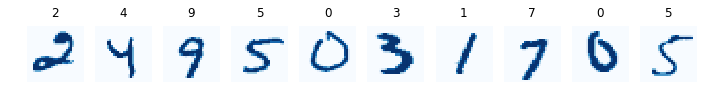

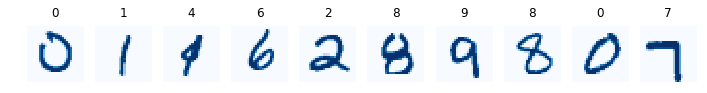

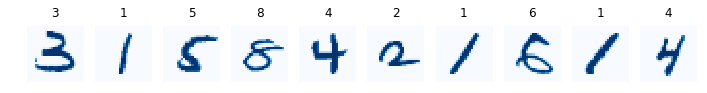

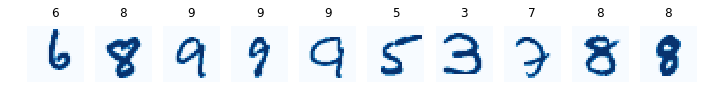

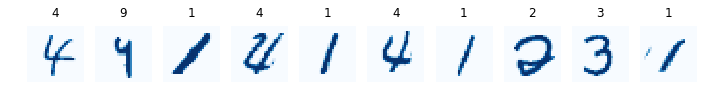

In [146]:
from keras.datasets import mnist

(mnist_examples, mnist_labels),(mnist_test_examples, mnist_test_labels) = mnist.load_data()

# Print the shape of the data tensors
print("MNIST size: ", mnist_examples.shape, " labels size: ", mnist_labels.shape)

# Display some random training examples
num_imgs = 10

# Display 50 images, darker color means higher signal
for i in range(5):
    index = np.random.choice(len(mnist_examples), num_imgs)

    f,ax = plt.subplots(1,num_imgs, figsize=(12, 12))

    for i, j in enumerate(index):
        ax[i].axis('off')
        ax[i].matshow(mnist_examples[j], cmap = "Blues")
        ax[i].set_title(mnist_labels[j])

    plt.show()

### Data preprocessing

It is common to preprocess the data in some ways to stabilize training. The following is some light preprocessing to make it fit with this ANN structure. The exact methods used are:
* Normalization : Reduce size of image values from [0, 255] to [0, 1]
* One Hot Encoding : Given a label of value $i$ we create a vector of desired size consisting of zeros except for the $i$:th index which will be set to 1 

In [147]:
mnist_examples, mnist_test_examples = normalize(mnist_examples), normalize(mnist_test_examples)

mnist_labels, mnist_test_labels = one_hot_encode_list(mnist_labels), one_hot_encode_list(mnist_test_labels)

mnist_examples.shape

(60000, 28, 28)

### Activation functions

The network can "tune" it's signals by use of activation functions. Here are implemented the most common ones used in ANNs'. All functins take as input the scalar (or vector or matrix) to be tuned, as well as d which is false by default, d is set to True if the functions is supposed to return the derivative.

>```identity```:
 This is the simplest function, it adds little in terms of functionality but if we want the raw signals from one layer to another, this can be used.

> ```relu``` :
 The Rectified linear unit. it will return the identity of all walues >= 0 it returns 0 otherwise. the derivative is thus 1 or 0 depending on the sign of each element.

> ```l_relu``` :
 Like ```relu``` this method will return the identity of elements >= 0 but allows for small negative values in an attempt to avoid the _"vanishing gradient"_ problem.

> ```sigmoid```:
 The sigmoi-function is perhaps one of the most famous activation functions, it has a property which clamps all values between 0 and 1 which comes in handy when we want to avoid overflow by the signals. The derivative also has the fortunate property of including the functions output value, meaning we can calculate the output and use it for the derivative if necessary.
 
> ```tanh```:
 The hypertbolic tangent has probably grown in popularity because of it's resemblance to the Sigmoid-function. Like Sigmoid it clamps the signal between two values. The values in question are -1 and 1.

In [148]:
############################################################################
### Activation Functions 

# All functins take as input the scalar (or vector or matrix) to be tuned,
# as well as d which is false by default, d is set to True if the functions
# is supposed to return the derivative.
############################################################################

def identity(x, d = False):
    if d == False:
        return x
    else:
        ones = np.ones(x.shape)
        return ones

def relu(x, d = False):
    if not d:
        return np.where(x > 0, x, 0)
    else:
        return np.where(x > 0, 1, 0)

def l_relu(x, d = False):
    if not d:
        return np.where(x > 0, x, x/10)
    else:
        return np.where(x > 0, 1, -1.0/10)
    
def sigmoid(x, d = False):
    s = 1. / (1. + np.exp(-x))
    if not d:
        return s
    else:
        return np.multiply(s, (1 - s))

def tanh(x, d = False):
    th = np.tanh(x)
    if not d:
        return th
    else:
        return  1 - np.power(th, 2)

> The functions are plotted below with matplotlib

   identity   
[-5 -4 -3 -2 -1  0  1  2  3  4  5]
   Derivative: 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


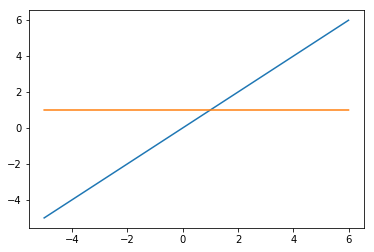

   ReLu   
[0 0 0 0 0 0 1 2 3 4 5]
   Derivative: 
[0 0 0 0 0 0 1 1 1 1 1]


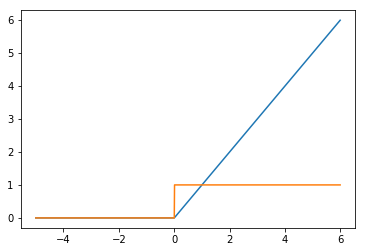

   l_ReLu   
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   1.   2.   3.   4.   5. ]
   Derivative: 
[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1  1.   1.   1.   1.   1. ]


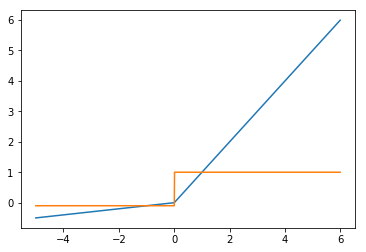

   Sigmoid   
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379 0.99330715]
   Derivative: 
[0.00664806 0.01766271 0.04517666 0.10499359 0.19661193 0.25
 0.19661193 0.10499359 0.04517666 0.01766271 0.00664806]


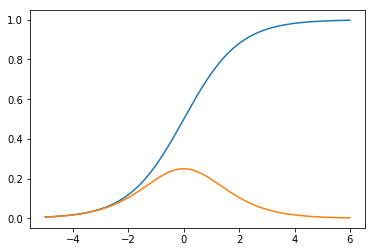

   TanH   
[-0.9999092  -0.9993293  -0.99505475 -0.96402758 -0.76159416  0.
  0.76159416  0.96402758  0.99505475  0.9993293   0.9999092 ]
   Derivative: 
[1.81583231e-04 1.34095068e-03 9.86603717e-03 7.06508249e-02
 4.19974342e-01 1.00000000e+00 4.19974342e-01 7.06508249e-02
 9.86603717e-03 1.34095068e-03 1.81583231e-04]


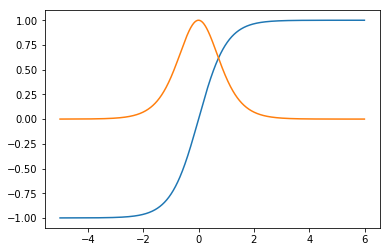

In [149]:
# Simple range of values for plots
t = np.arange(-5, 6, step = 1)
t_prim = np.arange(-5, 6, step = 0.01)

print("   identity   ")
print(identity(t))
print("   Derivative: ")
print(identity(t, d = True))
plt.plot(t_prim, identity(t_prim))
plt.plot(t_prim, identity(t_prim, d = True))
plt.show()

print("   ReLu   ")
print(relu(t))
print("   Derivative: ")
print(relu(t, d = True))
plt.plot(t_prim, relu(t_prim))
plt.plot(t_prim, relu(t_prim, d = True))
plt.show()

print("   l_ReLu   ")
print(l_relu(t))
print("   Derivative: ")
print(l_relu(t, d = True))
plt.plot(t_prim, l_relu(t_prim))
plt.plot(t_prim, l_relu(t_prim, d = True))
plt.show()

print("   Sigmoid   ")
print(sigmoid(t))
print("   Derivative: ")
print(sigmoid(t, d = True))
plt.plot(t_prim, sigmoid(t_prim))
plt.plot(t_prim, sigmoid(t_prim, d = True))
plt.show()

print("   TanH   ")
print(tanh(t))
print("   Derivative: ")
print(tanh(t, d = True))
plt.plot(t_prim, tanh(t_prim))
plt.plot(t_prim, tanh(t_prim, d = True))
plt.show()

### Loss function

These are functions which are used for measuring the correctness in the output.

>```MSE```: Mean Squared Error is usually used in regression problems (continuous measurements) but for MNIST classification it can still gain satisfying results. It measures the squared difference between each element in the output and the desired output.


In [151]:
# Each loss function takes the following parameters
# output        : The output prediction of the network
# expected      : The label for that particular prediction (the expected output)
# d             : The derivative is returned if this is true, False by default
# d_out         : Some error functions require the derivative signal of the output, default set to None

def MSE(output, expected, d = False, d_out = None):
    if not d:
        error = np.square(expected - output)
        return np.nan_to_num(error)
    else:
        error = np.multiply(np.subtract(output, expected), (np.matrix(d_out)))
        return np.nan_to_num(error)

### The ANN-class

The ANN is a simple feed forward network. For simplicity the network model itself can be represented as a collection of matrices. Once trained, the user need only provide a vector of size $i$ where is the amount of rows in the first weight matrix. The one requirement of the network is that all matrices displayed in a sequence are of the following form:

> Let $i, j, k$ be the size of the input-, hidden- and output-layer respectively. Then the matrices which make up the whole model will be $2$ matrices of the shapes: $(j \times i)$ and $(k \times j)$

A prediction is now calculated by multiplying the first weight matrix $(j \times i)$ with the $(i \times 1)$ sized input vector to produce a vector of size $(j \times 1)$. This process is repeated for each weight matrix until a vector of size $(k \times 1)$ is produced, which will be our prediction.

> **A note about bias:** For this structure I append a bias node to each layer in the network. this means that each weight matrix actually is of size $( j \times (i+1))$ to allow for use of the bias node (which always send a signal of 1 but this can be tuned by the weights connected from it to the next layer)

> **What is a layer?: **
The network takes two arguments upon initialization, one of these arguments is _sizes_. This is a list of integers, and each integer defines the size of each layer in the network. the first element in _sizes_ define the size of the input and the last element define the size of the output. It is with these that the networks weight matrices are created. For each given weight matrix, each row includes one element for each input neuron. This means that each row is a collection of weights that connects the previous layers neurons to one neuron in the next layer.

The ANN is optimized by using Batch Gradient Descent. This is done by first calculating the gradient of the loss (also known as the "error") in the prediction of the network using backpropagation. in order for the network to generalize better, a batch size is set. The batch size (in this case) indicates how many gradients we sum together before we use them to update the networks weights. This way we can measure many changes and update the network by the summed changes after a few gradient calculations. This saves a little bit of time as we do not need to update the network with every gradient calculation.

In [152]:
class NeuralNetwork:
    
    # This is called upon initialization of the NN object, note that the list provided to activation_functions
    #  must be of length: (length of sizes) - 1
    # sizes:                  A list of integers, one for each layer
    # activation_functions:   A list of activation functions for each layer except the input layer
    def __init__(self, sizes, activation_functions):
        
        self.sizes = sizes
        self.activation_functions = activation_functions
        
        # Generate random weights
        # we multiply by math.sqrt(2/ (j*i))) to give the weights a certain pattern from the beginning
        # Set i + 1 to include bias term in weigh
        self.weights = []
        [self.weights.append(np.random.random_sample((j, i + 1)) * math.sqrt(2/ (j*i)))
         for i, j in zip(self.sizes[:-1], self.sizes[1:])]
        
        # Set the default error function to MSE
        self.err = MSE

    # Feed-forwarding, the activations will be f(W*i + b)
    # input_vector:        Input vector, must be a column vector
    # dropout:             Probability of dropout in each layer
    def feed_forward(self, input_vector, dropout = 0):
        
        # Gathered signals
        signals = []
        derived_signals = []

        # reshape input vector to correct shape, just in case...
        input_vector = np.matrix(input_vector).reshape((input_vector.size, 1))
        
        # Append input as the first signal
        signals.append(layer_dropout(input_vector, p = dropout))
        # Derivative of input-signals
        derived_signals.append(self.activation_functions[0](input_vector, d = True))
        
        # For every combined weight matrix and activation function
        for w, f in zip(self.weights[:-1], self.activation_functions[:-1]):
            
            # Append bias value to vector
            signal = np.vstack((signals[-1], 1))
            # Save derivative of signal
            derived_signals.append(f(np.dot(w, signal), d = True))
            # Save the signal itself
            signals.append(layer_dropout(f(np.dot(w, signal), d = False), p = dropout))
        
        # Handle the output separately so that no dropout is appended to it
        
        # append bias
        signal = np.vstack((signals[-1], 1))
        # Save derivative of signal
        derived_signals.append(self.activation_functions[-1](np.dot(self.weights[-1], signal), d = True))
        # Save the signal itself
        signals.append(self.activation_functions[-1](np.dot(self.weights[-1], signal), d = False))

        # Return 2 things: the signals, the derived signals to be used in backpropagation
        return signals, derived_signals
    
    
    # This is the backpropagation algorithm
    # signals        : The signals from each layer
    # d_signals      : The derivative of the signals form each layer
    # out_error      : the error in each neuron in the output layer
    def backpropagate(self, signals, d_signals, out_error):

            # Error in each layer
        error_vectors = list() 
            # Gradient which will update the network
        gradient = list()
        
            # Append error in output layer
        output_error = np.multiply(out_error, d_signals[-1])
        error_vectors.append(output_error)
            
            #Note! We need to multiply our error by the signals leading into the output-layer
            #    We need this for updating the gradient, which is just the derivative of the error
            #    multiplied by the input from the previous layer
            
            
        output_error = output_error * np.vstack((signals[-2], 1)).T
        gradient.append(output_error)
        
            
            #We now repeat the above with on big exception:
            #     We need to take the previous error into concideration by multiplying with it,
            #     the first error was achieved by our costfunction, every other error is derived from the
            #     previous one and so on.
            
        for w in reversed(range(1, len(self.weights))):
            
            # The error in each hidden layer = E * W * d_X
            #    Where W are the weights we want to change, E is the error in the previous layer
            #    and X is the derived input signals from this layer
            
                # This multiplication results in a vector of the form (1, n), 
                # because I wrote this algorithm with column vectors in mind,
                # The transpose (n, 1) is saved for the next iteration

            error = np.multiply(error_vectors[-1], self.weights[w][:, :-1])
            error = np.sum(np.multiply(error, d_signals[w].T), axis = 0)
            
            error_vectors.append(error.T)
            
                # The gradient is in this case a matrix in the same form as the respective weight matrix.
                # For this reason we multiply our transposed error (n, 1) by the transposed signal (1, m)
                # resulting in a (n,m) matrix, neglecting this will result in a redundant scalar
                
            error = error.T * np.vstack((signals[w - 1], 1)).T
            gradient.append(error)
            
                # The only necessary update is now to suntract each weight
                # from the learning rate(alpha) multiplied by the gradient
            
        return gradient
    
    # This updates the weights with the gradient
    # gradient        : The summed changes to be made
    # alpha           : The learning rate, scales the gradient (usually a small float value)
    def update_w(self, gradient, alpha):
        for w in range(len(self.weights)):
            self.weights[w] -= alpha * gradient[-(w + 1)]
            
    # Performs learning on one batch, returns the error of the last prediction and the accuracy on the batch
    # examples        : training data
    # labels          : labels of training data
    # alpha           : learningn rate, default to 0.01
    # dropout         : the dropout rate of each layer
    def train_on_batch(self, examples, labels, 
                       alpha = 0.01, 
                       dropout = 0,
                       lamb = 0):
    
        # Lists for predictions made and gradient stored
        predictions = []
        accuracy = []
        grad = []
        [grad.append(np.zeros_like(i)) for i in reversed(self.weights)]
        
        
        for e, l in zip(examples, labels):

            s, d = self.feed_forward(e, dropout = dropout)
            
            # for classification, the highest value is accepted as the prediction
            predictions.append(np.argmax(s[-1]))
            if(predictions[-1] == np.argmax(l)):
                accuracy.append(1)
            
            d_pred_error = self.err(s[-1], l, d = True, d_out = d[-1])
            g = self.backpropagate(s, d, d_pred_error)

            for i in range(len(grad)):
                
                grad[i] += (g[i] / len(examples))
        
        self.update_w(grad, alpha)
        err = self.err(s[-1], l)
        
        return err, sum(accuracy) / len(examples)
    
    
    # Divide data into batches and start training
    # if validation data is given, a test will be made at the end of each epoch
    def bgdc(self, x, y,
         valid_examples = None, valid_labels = None,
         epochs = 16, 
         batches = 512, 
         batch_size = 128, 
         alpha = 0.01,
         dropout = 0):
        
        errs = []
        
        
        for e in range(epochs):
            #t = tqdm_notebook(range(batches), desc = "", leave = True)
            losses = []
            accs = []
            timer = time.time()
            #for b in t:
            for b in range(batches):
                batch_index = np.random.choice(len(x), batch_size)

                data_x = x[batch_index]
                data_y = y[batch_index]

                err, acc = self.train_on_batch(data_x, data_y,
                                    alpha = alpha, 
                                    dropout = dropout)
                
                errs.append(np.sum(err))
                losses.append(np.sum(err))
                accs.append(acc)
                
                #t.desc = "Epoch: " + str(e + 1) + ", Avg. Loss: " + str(sum(losses)/len(losses), ", Avg. accuracy: " + str(sum(accs)/len(accs))
                #t.refresh()
            print("Epoch: " + str(e + 1) + ", Avg. Loss: " + str(sum(losses)/len(losses)) + ", Avg. accuracy: " + str(sum(accs)/len(accs)))
            print("Time: " + str( round(time.time() - timer)) + " seconds")
            if not valid_examples is None and not valid_labels is None:
                print("Validation Accuracy")
                self.test(valid_examples, valid_labels)

        print(max(errs), min(errs))
        plt.subplots(figsize=(30,20))
        plt.title("Error over iterations")
        plt.plot(errs)
        plt.show()

    
    # A method for testing the networks accuracy
    # Only makes sense in the case of classification
    def test(self, examples, labels):
        acc = 0

        predictions = []
        ls = []
        for e, l in zip(examples, labels):

            pred, d = self.feed_forward(e, dropout= 0)

            pred = np.argmax(pred[-1])
            l = np.argmax(l)
            predictions.append(pred)
            ls.append(l)
            
            if(pred == l):
                acc += 1
        
        print(acc, "/", len(examples))
        plt.title("Predictions")
        plt.hist([predictions, ls], label = ["prediction", "true_label"], color = ["cyan", "magenta"])
        plt.xticks(range(0, 9))
        plt.legend(loc = "upper right")
        plt.show()


# Training on MNIST

The following is a network trained for MNIST. I will test different architectures and leave the one which works best.
> ## The architecture
For MNIST_net I decided to keep a simple structure. The input layer consists of 748 neurons, which is the square of 28 (the image dimension). I opted to use only one hidden layer consisting of 100 neurons. This is because I want to allow the network to make a transition from 28*28 to the output layer (which consists of 10 neurons). It is of course dangerous to assume an architecture works better than an other based on simple principles. But I realized that the network produces (somewhat) satisfying results.

> ## The plan
As for the experiment I have decided to test one network which use different activation functions. These are tanh, sigmoid and relu. I tested a combination of the three in the same network but convergence took too long and never quite reached a satisfying result, so I decided agains it. Instead I will train networks using one unique activation function in each layer and then compare the weights formed after training.


### ```tanh```

Epoch: 1, Avg. Loss: 0.5896040320833361, Avg. accuracy: 0.7439666666666674
Time: 34 seconds
Validation Accuracy
8581 / 10000


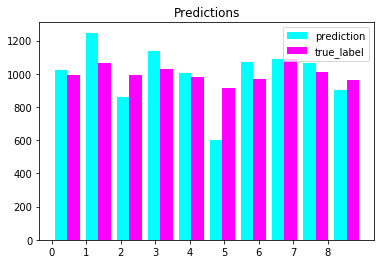

Epoch: 2, Avg. Loss: 0.46562829423731555, Avg. accuracy: 0.8379000000000011
Time: 35 seconds
Validation Accuracy
8747 / 10000


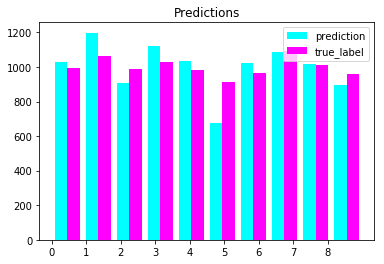

Epoch: 3, Avg. Loss: 0.46214403388166064, Avg. accuracy: 0.8450333333333343
Time: 34 seconds
Validation Accuracy
8793 / 10000


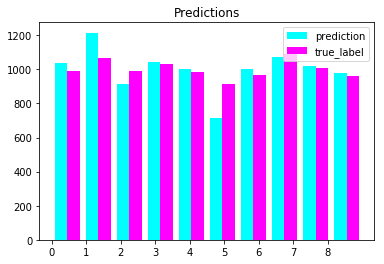

Epoch: 4, Avg. Loss: 0.4577895583560409, Avg. accuracy: 0.8539333333333343
Time: 35 seconds
Validation Accuracy
8756 / 10000


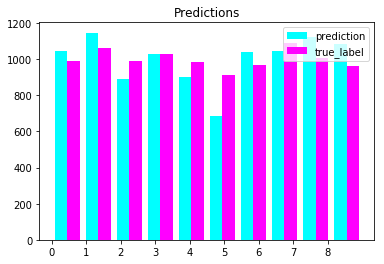

Epoch: 5, Avg. Loss: 0.41696875007635964, Avg. accuracy: 0.8573666666666669
Time: 32 seconds
Validation Accuracy
8766 / 10000


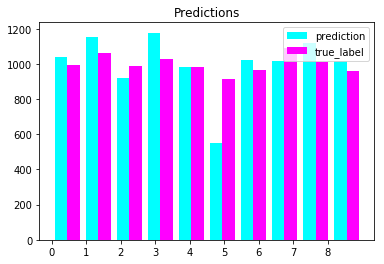

Epoch: 6, Avg. Loss: 0.43312758936355655, Avg. accuracy: 0.8621666666666666
Time: 37 seconds
Validation Accuracy
8874 / 10000


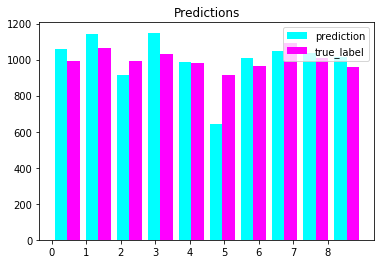

Epoch: 7, Avg. Loss: 0.4092530626080965, Avg. accuracy: 0.8684333333333336
Time: 35 seconds
Validation Accuracy
8951 / 10000


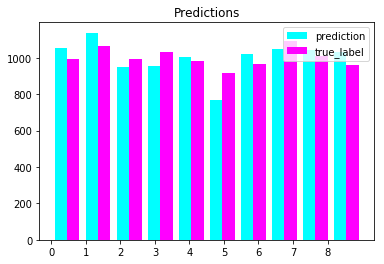

Epoch: 8, Avg. Loss: 0.39130855422379535, Avg. accuracy: 0.8715666666666664
Time: 33 seconds
Validation Accuracy
8954 / 10000


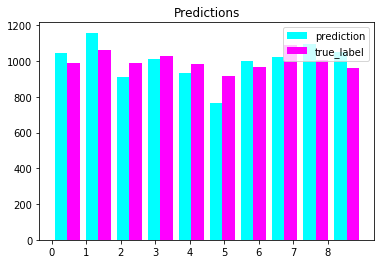

Epoch: 9, Avg. Loss: 0.38667944060604725, Avg. accuracy: 0.8711333333333331
Time: 33 seconds
Validation Accuracy
8972 / 10000


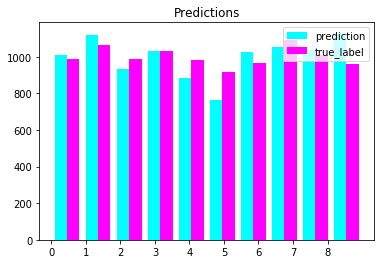

Epoch: 10, Avg. Loss: 0.37136595748950246, Avg. accuracy: 0.8790999999999993
Time: 29 seconds
Validation Accuracy
8995 / 10000


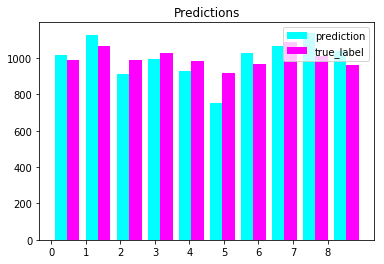

Epoch: 11, Avg. Loss: 0.3637120838442018, Avg. accuracy: 0.8785666666666663
Time: 33 seconds
Validation Accuracy
9050 / 10000


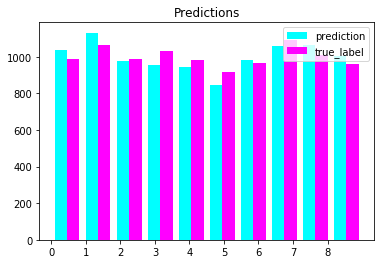

Epoch: 12, Avg. Loss: 0.38486276732648106, Avg. accuracy: 0.8809333333333325
Time: 29 seconds
Validation Accuracy
8989 / 10000


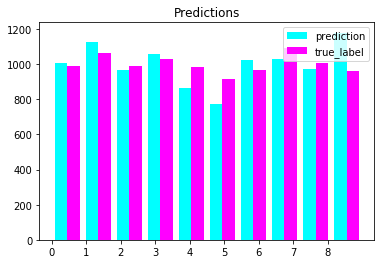

Epoch: 13, Avg. Loss: 0.36094879062168694, Avg. accuracy: 0.8846333333333327
Time: 32 seconds
Validation Accuracy
9091 / 10000


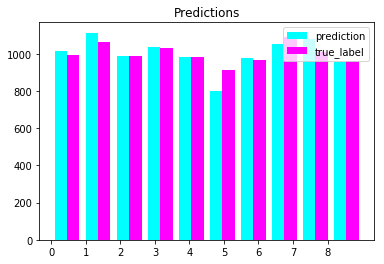

Epoch: 14, Avg. Loss: 0.358536012228521, Avg. accuracy: 0.8904666666666664
Time: 33 seconds
Validation Accuracy
9095 / 10000


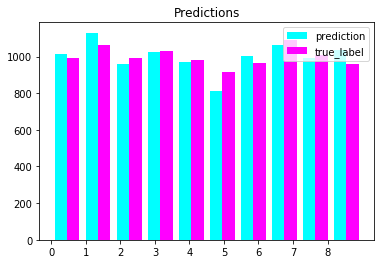

Epoch: 15, Avg. Loss: 0.377237997551392, Avg. accuracy: 0.8897333333333325
Time: 30 seconds
Validation Accuracy
9085 / 10000


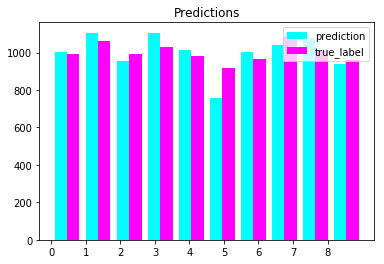

Epoch: 16, Avg. Loss: 0.342972524336914, Avg. accuracy: 0.8896333333333333
Time: 34 seconds
Validation Accuracy
8960 / 10000


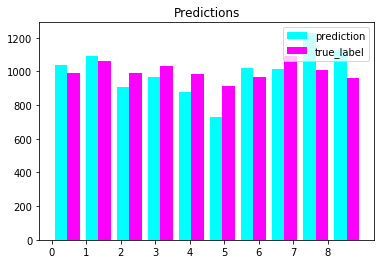

Epoch: 17, Avg. Loss: 0.36456521409651244, Avg. accuracy: 0.8906999999999999
Time: 33 seconds
Validation Accuracy
9104 / 10000


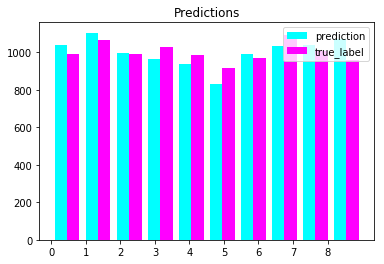

Epoch: 18, Avg. Loss: 0.3710129390955003, Avg. accuracy: 0.8956999999999994
Time: 33 seconds
Validation Accuracy
9134 / 10000


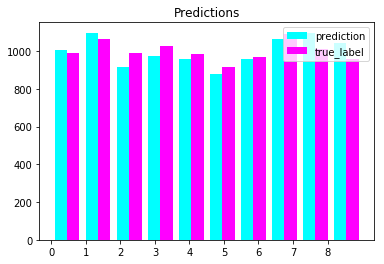

Epoch: 19, Avg. Loss: 0.3250436372716569, Avg. accuracy: 0.8991333333333322
Time: 34 seconds
Validation Accuracy
9090 / 10000


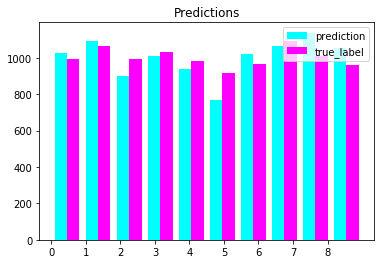

Epoch: 20, Avg. Loss: 0.3325332461959511, Avg. accuracy: 0.8951999999999994
Time: 33 seconds
Validation Accuracy
9158 / 10000


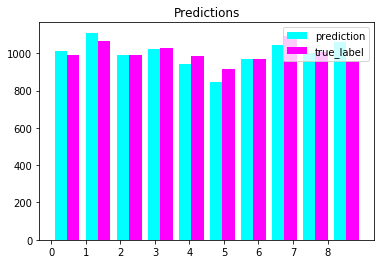

Epoch: 21, Avg. Loss: 0.3294746844386343, Avg. accuracy: 0.8950999999999988
Time: 34 seconds
Validation Accuracy
9129 / 10000


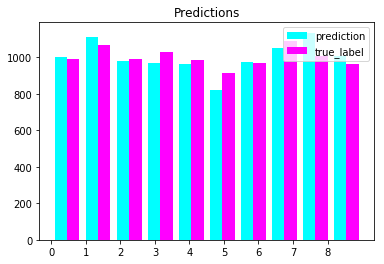

Epoch: 22, Avg. Loss: 0.30550855991361964, Avg. accuracy: 0.9021999999999988
Time: 34 seconds
Validation Accuracy
9136 / 10000


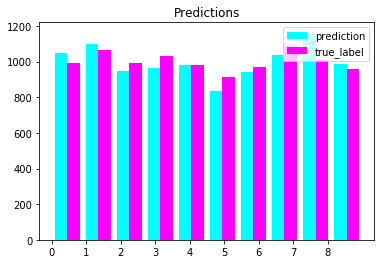

Epoch: 23, Avg. Loss: 0.3025891566942093, Avg. accuracy: 0.8997666666666665
Time: 34 seconds
Validation Accuracy
9164 / 10000


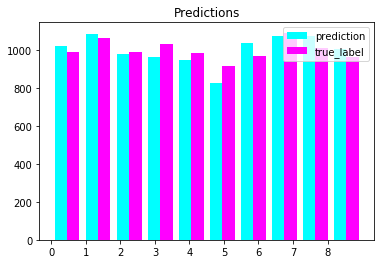

Epoch: 24, Avg. Loss: 0.31503695166322404, Avg. accuracy: 0.9001999999999994
Time: 34 seconds
Validation Accuracy
9171 / 10000


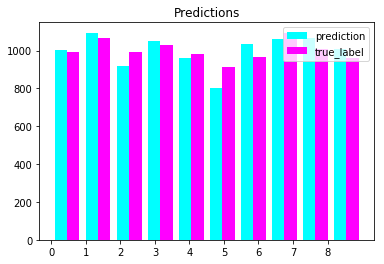

Epoch: 25, Avg. Loss: 0.3068928678881137, Avg. accuracy: 0.9023666666666657
Time: 34 seconds
Validation Accuracy
9134 / 10000


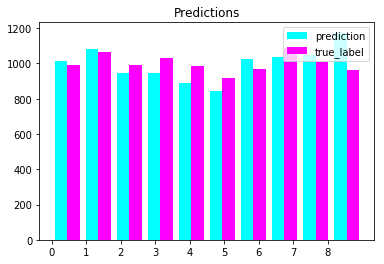

Epoch: 26, Avg. Loss: 0.2797081575429995, Avg. accuracy: 0.900966666666666
Time: 34 seconds
Validation Accuracy
9170 / 10000


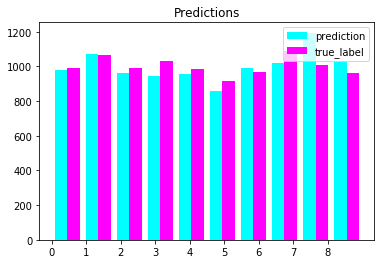

Epoch: 27, Avg. Loss: 0.2872406434914124, Avg. accuracy: 0.9018666666666655
Time: 34 seconds
Validation Accuracy
9204 / 10000


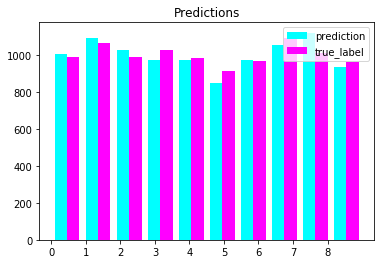

Epoch: 28, Avg. Loss: 0.296003345804392, Avg. accuracy: 0.9044999999999995
Time: 34 seconds
Validation Accuracy
9210 / 10000


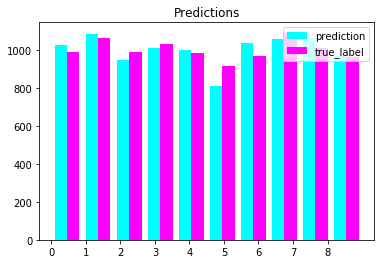

Epoch: 29, Avg. Loss: 0.3035632181470726, Avg. accuracy: 0.9056666666666655
Time: 33 seconds
Validation Accuracy
9230 / 10000


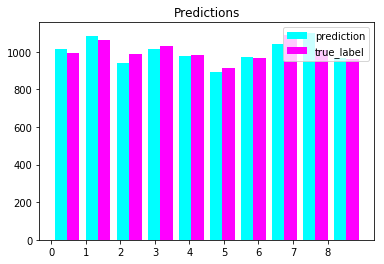

Epoch: 30, Avg. Loss: 0.30441267440101194, Avg. accuracy: 0.9048999999999991
Time: 34 seconds
Validation Accuracy
9204 / 10000


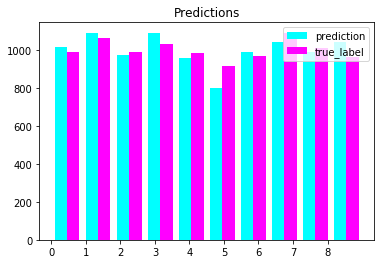

Epoch: 31, Avg. Loss: 0.2852598434888999, Avg. accuracy: 0.9036333333333331
Time: 34 seconds
Validation Accuracy
9224 / 10000


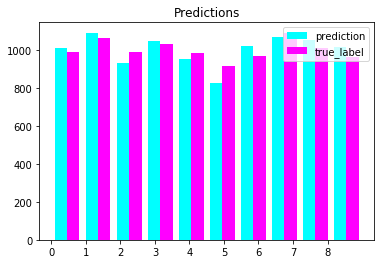

Epoch: 32, Avg. Loss: 0.3237777220001635, Avg. accuracy: 0.9055333333333326
Time: 32 seconds
Validation Accuracy
9241 / 10000


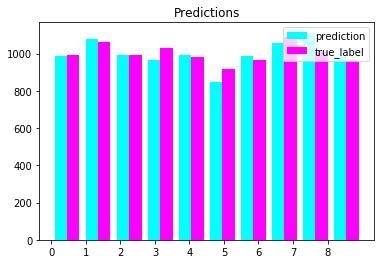

Epoch: 33, Avg. Loss: 0.30348770755941007, Avg. accuracy: 0.9067666666666656
Time: 34 seconds
Validation Accuracy
9245 / 10000


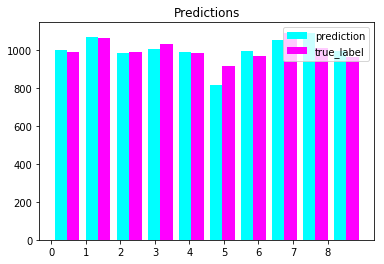

Epoch: 34, Avg. Loss: 0.29231957914021983, Avg. accuracy: 0.9085333333333322
Time: 30 seconds
Validation Accuracy
9222 / 10000


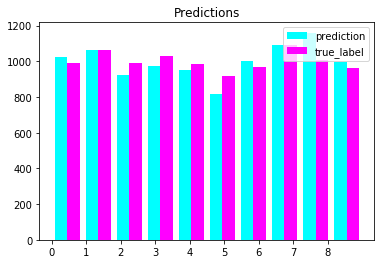

Epoch: 35, Avg. Loss: 0.31494115251702626, Avg. accuracy: 0.9082333333333323
Time: 34 seconds
Validation Accuracy
9265 / 10000


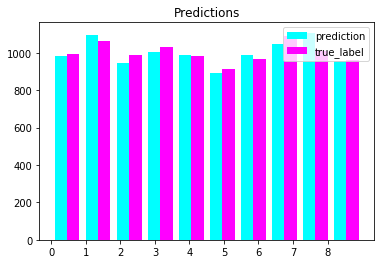

Epoch: 36, Avg. Loss: 0.29016007821095285, Avg. accuracy: 0.9075333333333331
Time: 34 seconds
Validation Accuracy
9191 / 10000


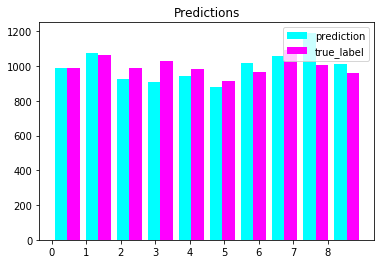

Epoch: 37, Avg. Loss: 0.26846222048299423, Avg. accuracy: 0.9084666666666658
Time: 34 seconds
Validation Accuracy
9226 / 10000


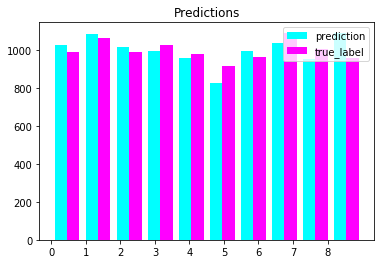

Epoch: 38, Avg. Loss: 0.2947130815782998, Avg. accuracy: 0.9082333333333327
Time: 33 seconds
Validation Accuracy
9230 / 10000


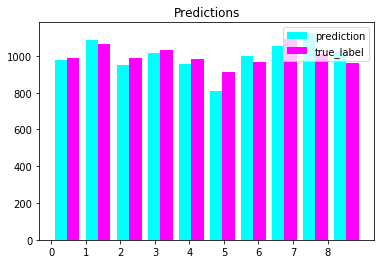

Epoch: 39, Avg. Loss: 0.287980710471907, Avg. accuracy: 0.9109999999999991
Time: 34 seconds
Validation Accuracy
9229 / 10000


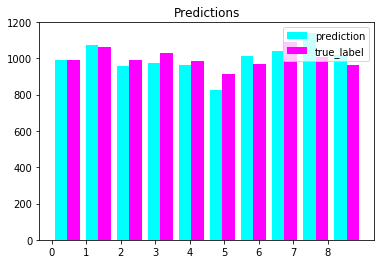

Epoch: 40, Avg. Loss: 0.2942200877535754, Avg. accuracy: 0.9097666666666657
Time: 34 seconds
Validation Accuracy
9252 / 10000


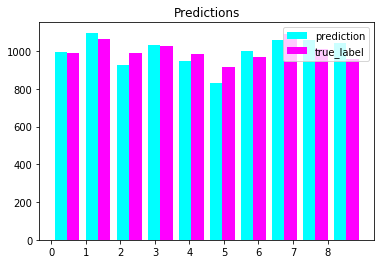

2.152562451995882 0.039979296086276275


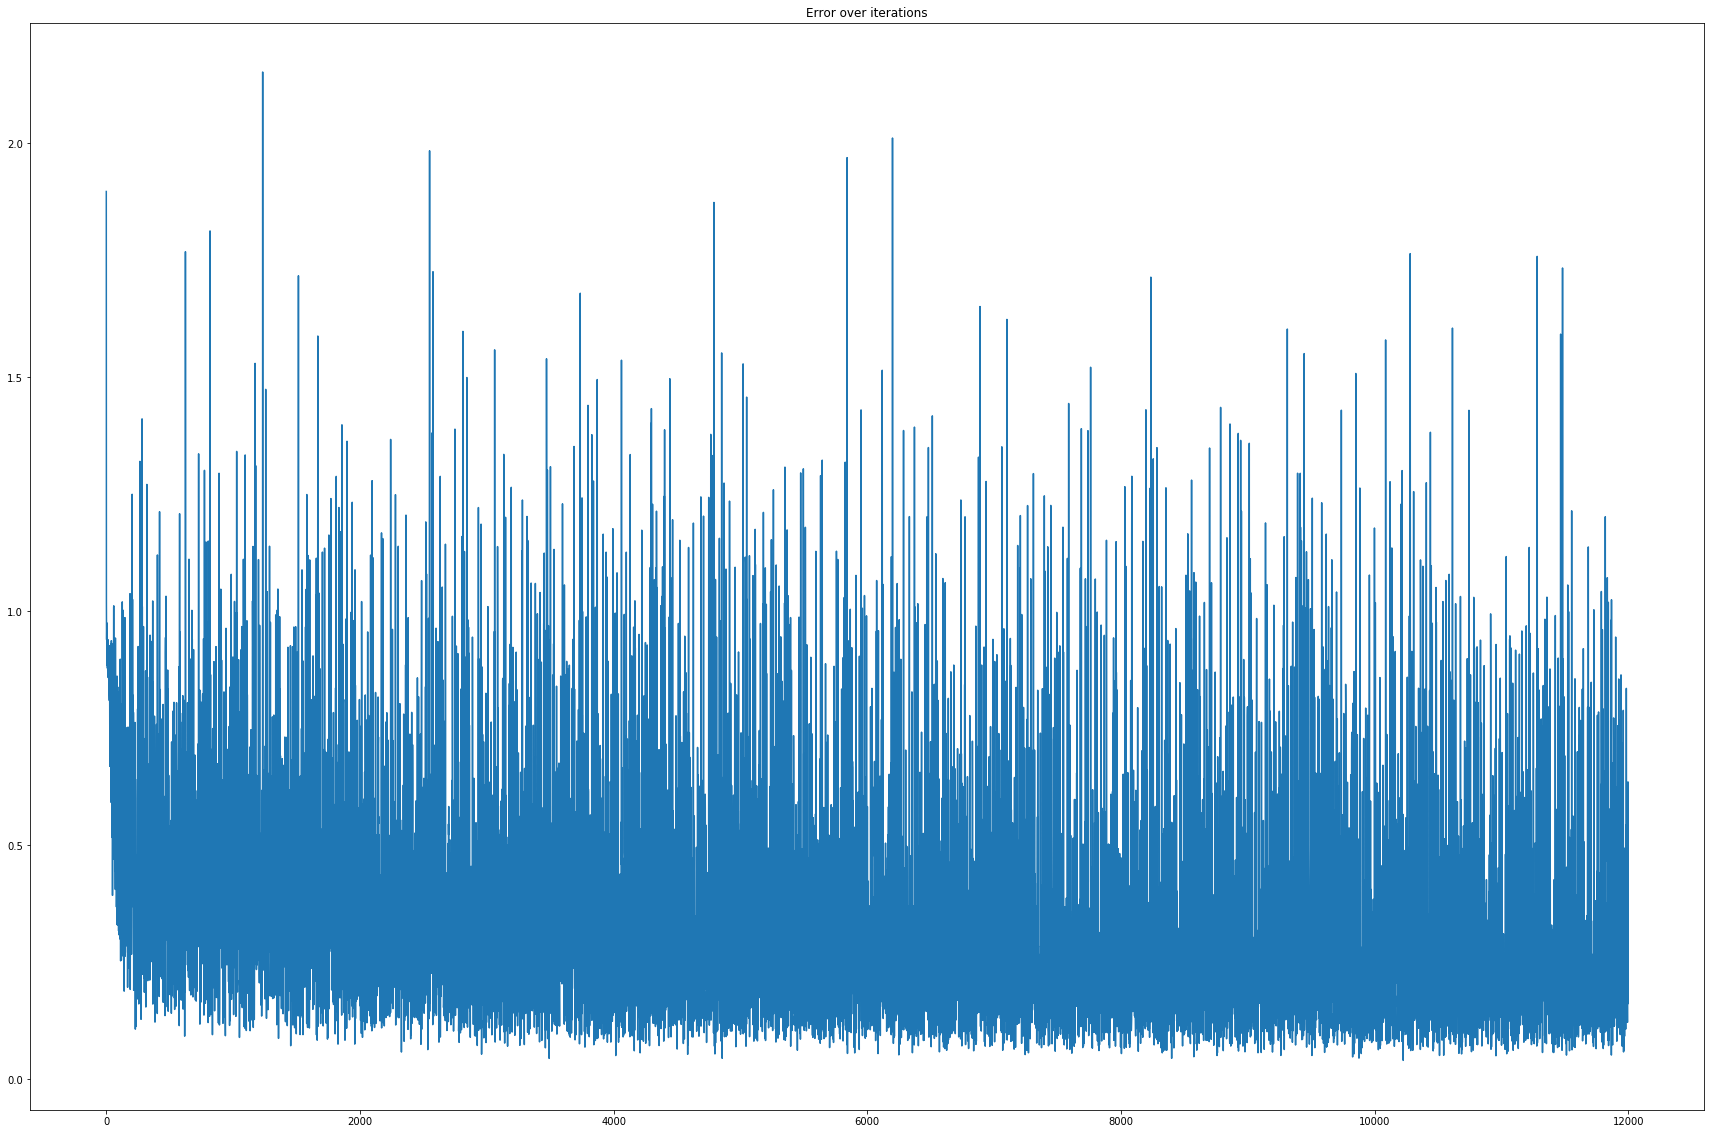

In [160]:
layers = [28**2, 100, 10]
activations = [tanh, tanh]
np.random.seed(0)
mnist_net_tanh = NeuralNetwork(layers, activations)

mnist_net_tanh.bgdc(mnist_examples[0:50000], mnist_labels[0:50000],
              mnist_examples[50000:60000], mnist_labels[50000: 60000],
              epochs = 40,
              batches = 300,
              batch_size = 100,
              alpha = 0.1,
              dropout = 0.1)

9241 / 10000


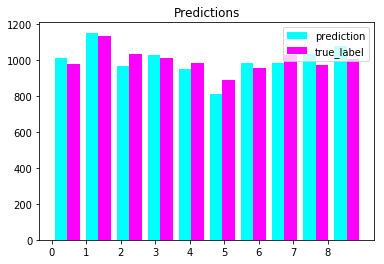

In [161]:
# Network performance on test data

mnist_net_tanh.test(mnist_test_examples, mnist_test_labels)

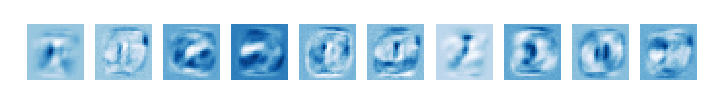

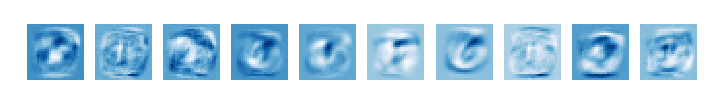

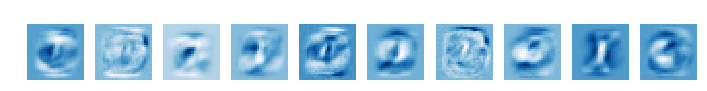

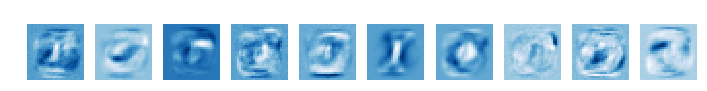

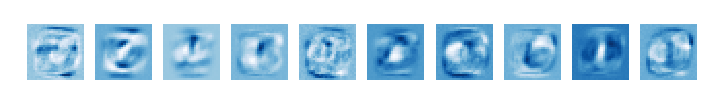

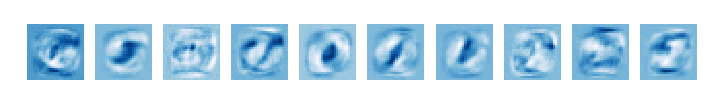

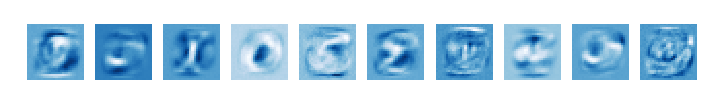

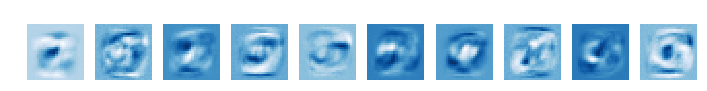

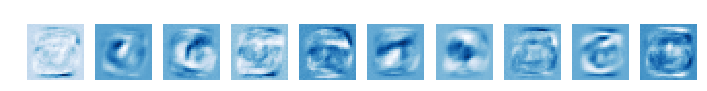

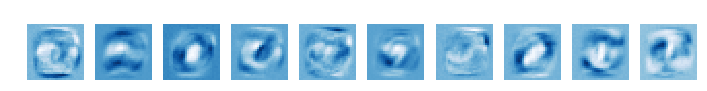

Summed weights: 


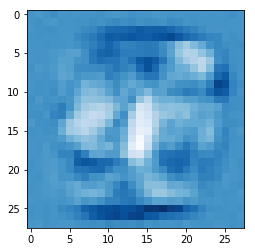

In [162]:
# Weights from input to hidden layer, 
# one image indicate signal strength from every input neuron to one hidden neuron

img_dim = (28, 28)
display_weights(mnist_net_tanh.weights[0], img_dim)

> After one epoch the network manages to achieve over $80$% accuracy on the validation data. From then it is a slow increase in predictive performance until the number of epochs expires. Somewhere around the $25th$ epoch performance starts oscilating between $89$% and $93$% accuracy. The error (graphed at the end of the list) from the whole training process seems to oscilate between $0$ and $2$ for the whole training process. My guess is that this could be remedied by increasing the amount of epochs and batches, however this would inevitably increase the time required for training. Training this particular network takes roughly $22$ minutes ($34$ seconds for each epoch). The dropout rate is $0.1$, meaning one percent of each layer (except the output-layer) is excluded in training, promoting generalization of te network. A sign of generalization is show when the average accuracy of an epoch is less than the accuracy of the validation data (shown in each histogram). Displaying the accuracy available on new data. This is also evident in the test-accuracy, which results in roughly $92$%

### ```sigmoid```

Epoch: 1, Avg. Loss: 0.9321387162381122, Avg. accuracy: 0.11103333333333332
Time: 59 seconds
Validation Accuracy
1064 / 10000


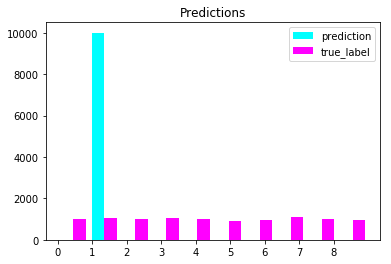

Epoch: 2, Avg. Loss: 0.9008345139410883, Avg. accuracy: 0.11393333333333323
Time: 58 seconds
Validation Accuracy
1064 / 10000


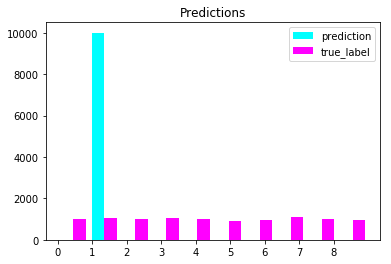

Epoch: 3, Avg. Loss: 0.89653341401429, Avg. accuracy: 0.11423333333333324
Time: 58 seconds
Validation Accuracy
1064 / 10000


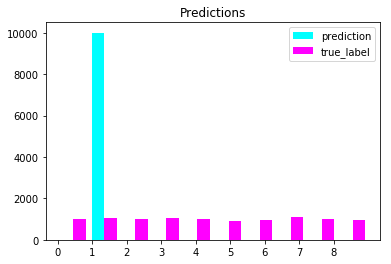

Epoch: 4, Avg. Loss: 0.8956875493926943, Avg. accuracy: 0.1140333333333333
Time: 58 seconds
Validation Accuracy
1066 / 10000


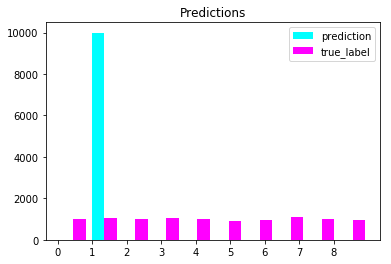

Epoch: 5, Avg. Loss: 0.8809723650083267, Avg. accuracy: 0.1226666666666666
Time: 58 seconds
Validation Accuracy
1651 / 10000


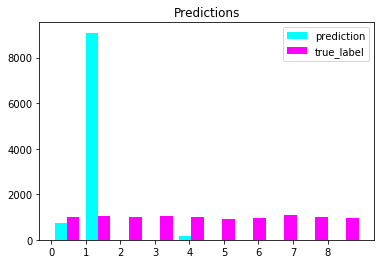

Epoch: 6, Avg. Loss: 0.8456048986225708, Avg. accuracy: 0.21863333333333343
Time: 58 seconds
Validation Accuracy
2051 / 10000


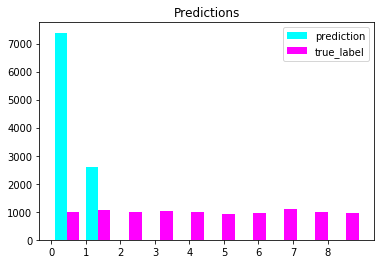

Epoch: 7, Avg. Loss: 0.8031414722630313, Avg. accuracy: 0.2514333333333333
Time: 58 seconds
Validation Accuracy
2691 / 10000


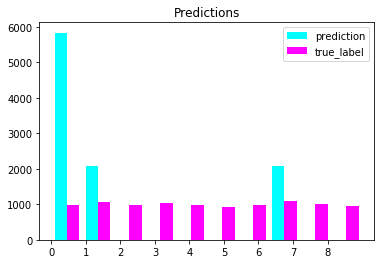

Epoch: 8, Avg. Loss: 0.7467604103504014, Avg. accuracy: 0.3133666666666665
Time: 59 seconds
Validation Accuracy
3640 / 10000


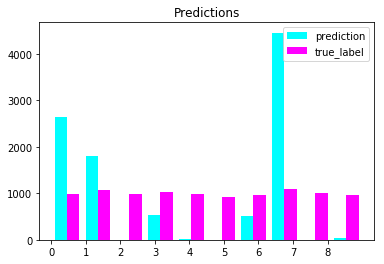

Epoch: 9, Avg. Loss: 0.6816298342549295, Avg. accuracy: 0.4132333333333336
Time: 59 seconds
Validation Accuracy
5035 / 10000


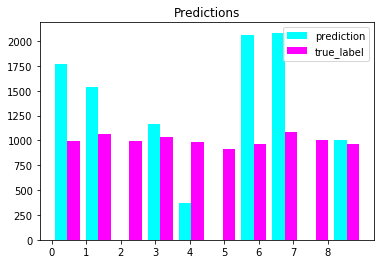

Epoch: 10, Avg. Loss: 0.6474816263494328, Avg. accuracy: 0.5245000000000002
Time: 59 seconds
Validation Accuracy
6036 / 10000


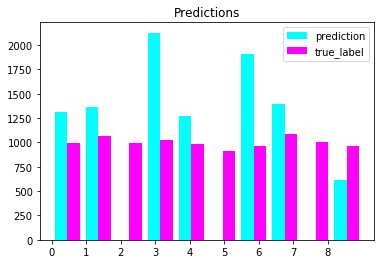

Epoch: 11, Avg. Loss: 0.5689094183419138, Avg. accuracy: 0.5815666666666671
Time: 58 seconds
Validation Accuracy
6317 / 10000


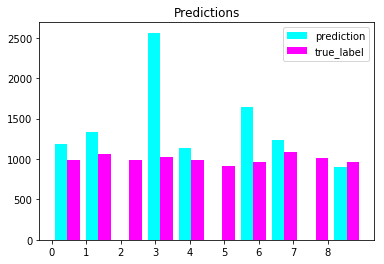

Epoch: 12, Avg. Loss: 0.5470619108524108, Avg. accuracy: 0.6184666666666665
Time: 58 seconds
Validation Accuracy
6905 / 10000


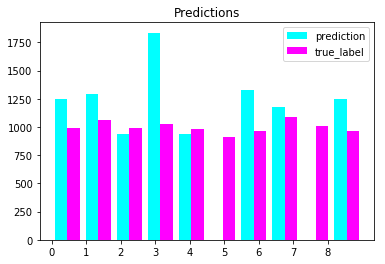

Epoch: 13, Avg. Loss: 0.46813125810081707, Avg. accuracy: 0.6737666666666662
Time: 59 seconds
Validation Accuracy
7268 / 10000


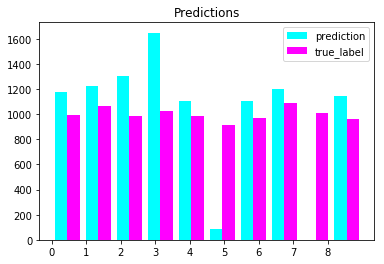

Epoch: 14, Avg. Loss: 0.47390117055391584, Avg. accuracy: 0.7141333333333327
Time: 59 seconds
Validation Accuracy
7586 / 10000


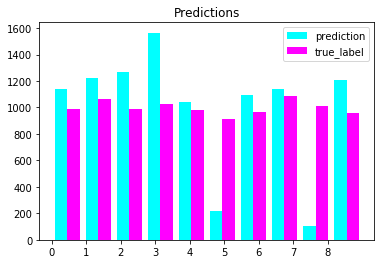

Epoch: 15, Avg. Loss: 0.4365171948979233, Avg. accuracy: 0.7468333333333335
Time: 59 seconds
Validation Accuracy
7862 / 10000


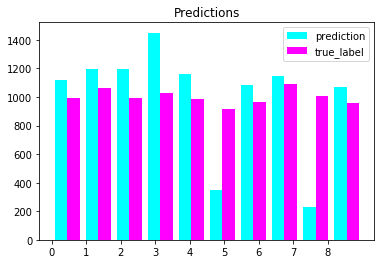

Epoch: 16, Avg. Loss: 0.37475542125290945, Avg. accuracy: 0.7772000000000002
Time: 59 seconds
Validation Accuracy
8333 / 10000


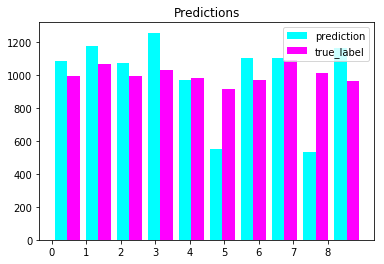

Epoch: 17, Avg. Loss: 0.38357049145160216, Avg. accuracy: 0.8055000000000008
Time: 58 seconds
Validation Accuracy
8549 / 10000


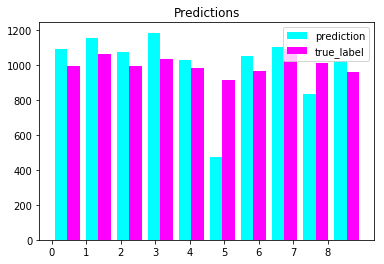

Epoch: 18, Avg. Loss: 0.3941274209094605, Avg. accuracy: 0.8295333333333338
Time: 58 seconds
Validation Accuracy
8714 / 10000


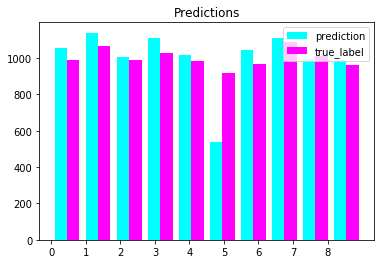

Epoch: 19, Avg. Loss: 0.29769279896153816, Avg. accuracy: 0.8436333333333343
Time: 58 seconds
Validation Accuracy
8781 / 10000


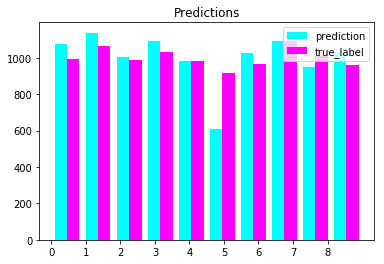

Epoch: 20, Avg. Loss: 0.2968478139649403, Avg. accuracy: 0.8475333333333341
Time: 58 seconds
Validation Accuracy
8835 / 10000


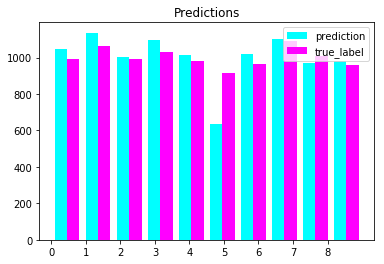

Epoch: 21, Avg. Loss: 0.30049969921631076, Avg. accuracy: 0.8557666666666669
Time: 58 seconds
Validation Accuracy
8874 / 10000


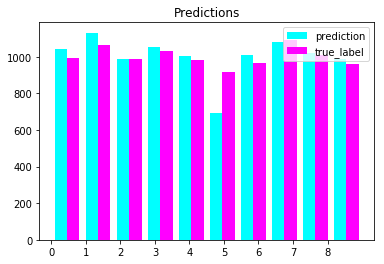

Epoch: 22, Avg. Loss: 0.2315172834489061, Avg. accuracy: 0.8685333333333337
Time: 58 seconds
Validation Accuracy
8911 / 10000


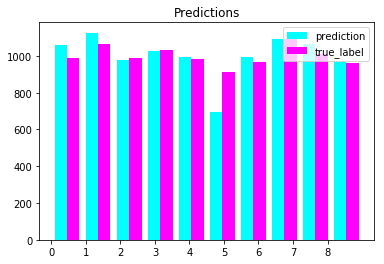

Epoch: 23, Avg. Loss: 0.23575045975019368, Avg. accuracy: 0.8659000000000006
Time: 58 seconds
Validation Accuracy
8965 / 10000


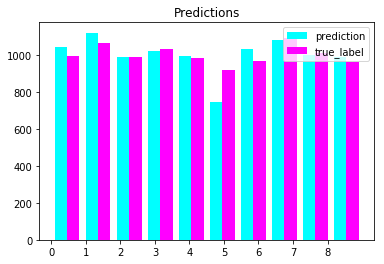

Epoch: 24, Avg. Loss: 0.25108503205807886, Avg. accuracy: 0.8693333333333334
Time: 58 seconds
Validation Accuracy
9002 / 10000


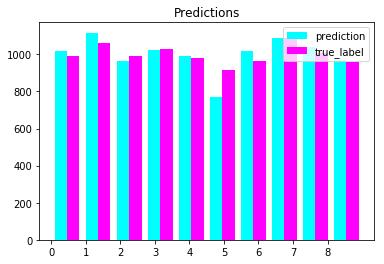

Epoch: 25, Avg. Loss: 0.22052923501889887, Avg. accuracy: 0.8750333333333326
Time: 58 seconds
Validation Accuracy
8999 / 10000


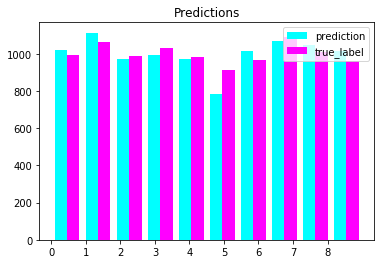

Epoch: 26, Avg. Loss: 0.1951478508688888, Avg. accuracy: 0.8729666666666664
Time: 59 seconds
Validation Accuracy
9040 / 10000


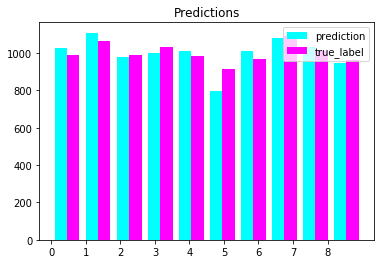

Epoch: 27, Avg. Loss: 0.19541052042152035, Avg. accuracy: 0.8801666666666665
Time: 59 seconds
Validation Accuracy
9050 / 10000


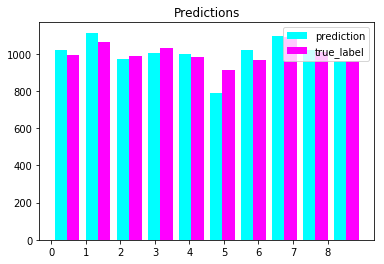

Epoch: 28, Avg. Loss: 0.19778030920416156, Avg. accuracy: 0.879933333333333
Time: 58 seconds
Validation Accuracy
9066 / 10000


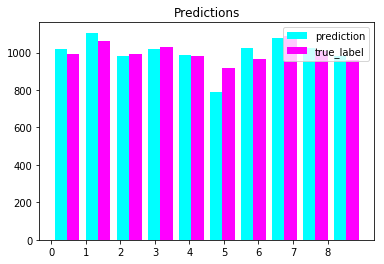

Epoch: 29, Avg. Loss: 0.20965847694422257, Avg. accuracy: 0.8824666666666663
Time: 57 seconds
Validation Accuracy
9082 / 10000


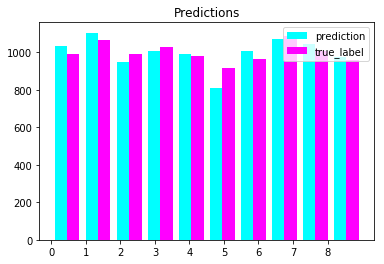

Epoch: 30, Avg. Loss: 0.2178215368804392, Avg. accuracy: 0.8837999999999991
Time: 58 seconds
Validation Accuracy
9090 / 10000


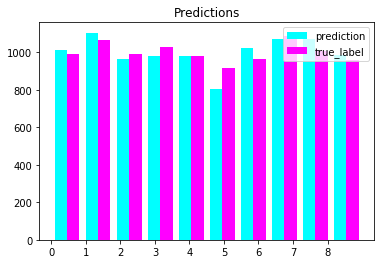

Epoch: 31, Avg. Loss: 0.18566640945280585, Avg. accuracy: 0.8847999999999995
Time: 53 seconds
Validation Accuracy
9100 / 10000


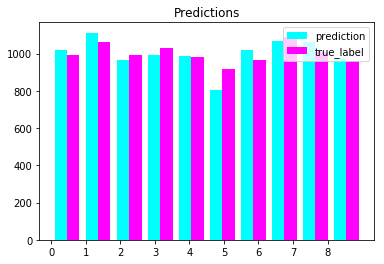

Epoch: 32, Avg. Loss: 0.23572122885855967, Avg. accuracy: 0.8863333333333329
Time: 58 seconds
Validation Accuracy
9122 / 10000


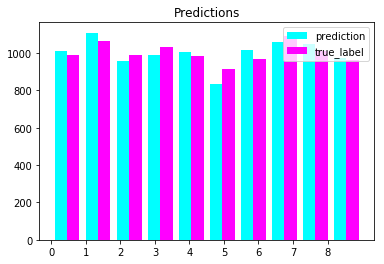

Epoch: 33, Avg. Loss: 0.21352428387224534, Avg. accuracy: 0.8861666666666654
Time: 59 seconds
Validation Accuracy
9139 / 10000


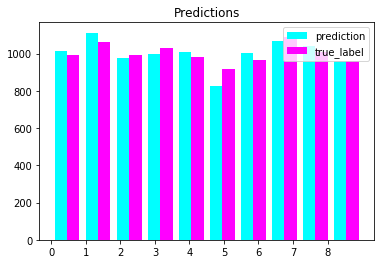

Epoch: 34, Avg. Loss: 0.19231294152135636, Avg. accuracy: 0.8893999999999992
Time: 57 seconds
Validation Accuracy
9143 / 10000


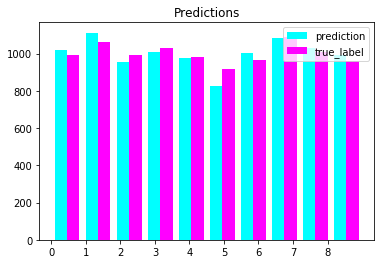

Epoch: 35, Avg. Loss: 0.21925685037187292, Avg. accuracy: 0.8915999999999987
Time: 58 seconds
Validation Accuracy
9131 / 10000


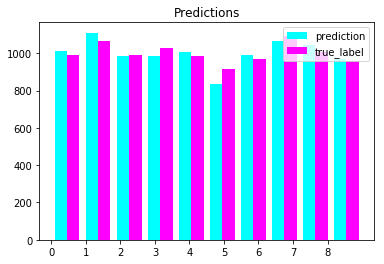

Epoch: 36, Avg. Loss: 0.19077828882819434, Avg. accuracy: 0.8902999999999995
Time: 58 seconds
Validation Accuracy
9152 / 10000


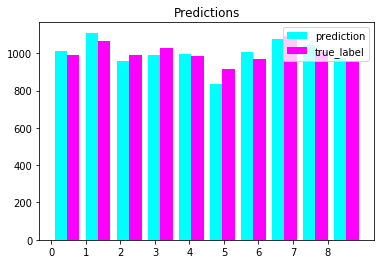

Epoch: 37, Avg. Loss: 0.15989838676583076, Avg. accuracy: 0.8918666666666656
Time: 59 seconds
Validation Accuracy
9165 / 10000


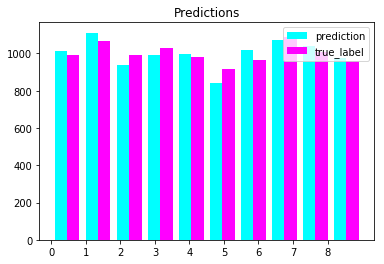

Epoch: 38, Avg. Loss: 0.2051326207090885, Avg. accuracy: 0.8933999999999994
Time: 58 seconds
Validation Accuracy
9165 / 10000


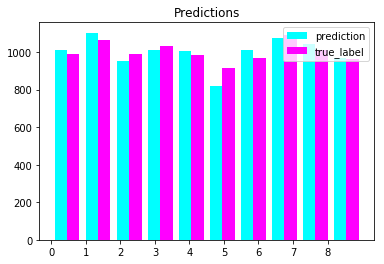

Epoch: 39, Avg. Loss: 0.1859342857400224, Avg. accuracy: 0.8952666666666668
Time: 57 seconds
Validation Accuracy
9169 / 10000


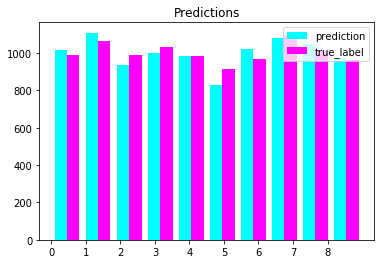

Epoch: 40, Avg. Loss: 0.18796417430279994, Avg. accuracy: 0.8972999999999992
Time: 58 seconds
Validation Accuracy
9176 / 10000


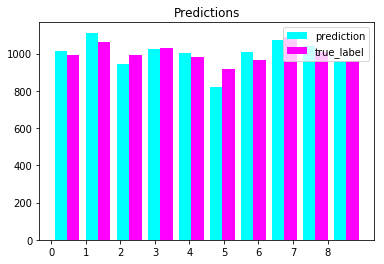

5.198003549683691 0.00020794177967596833


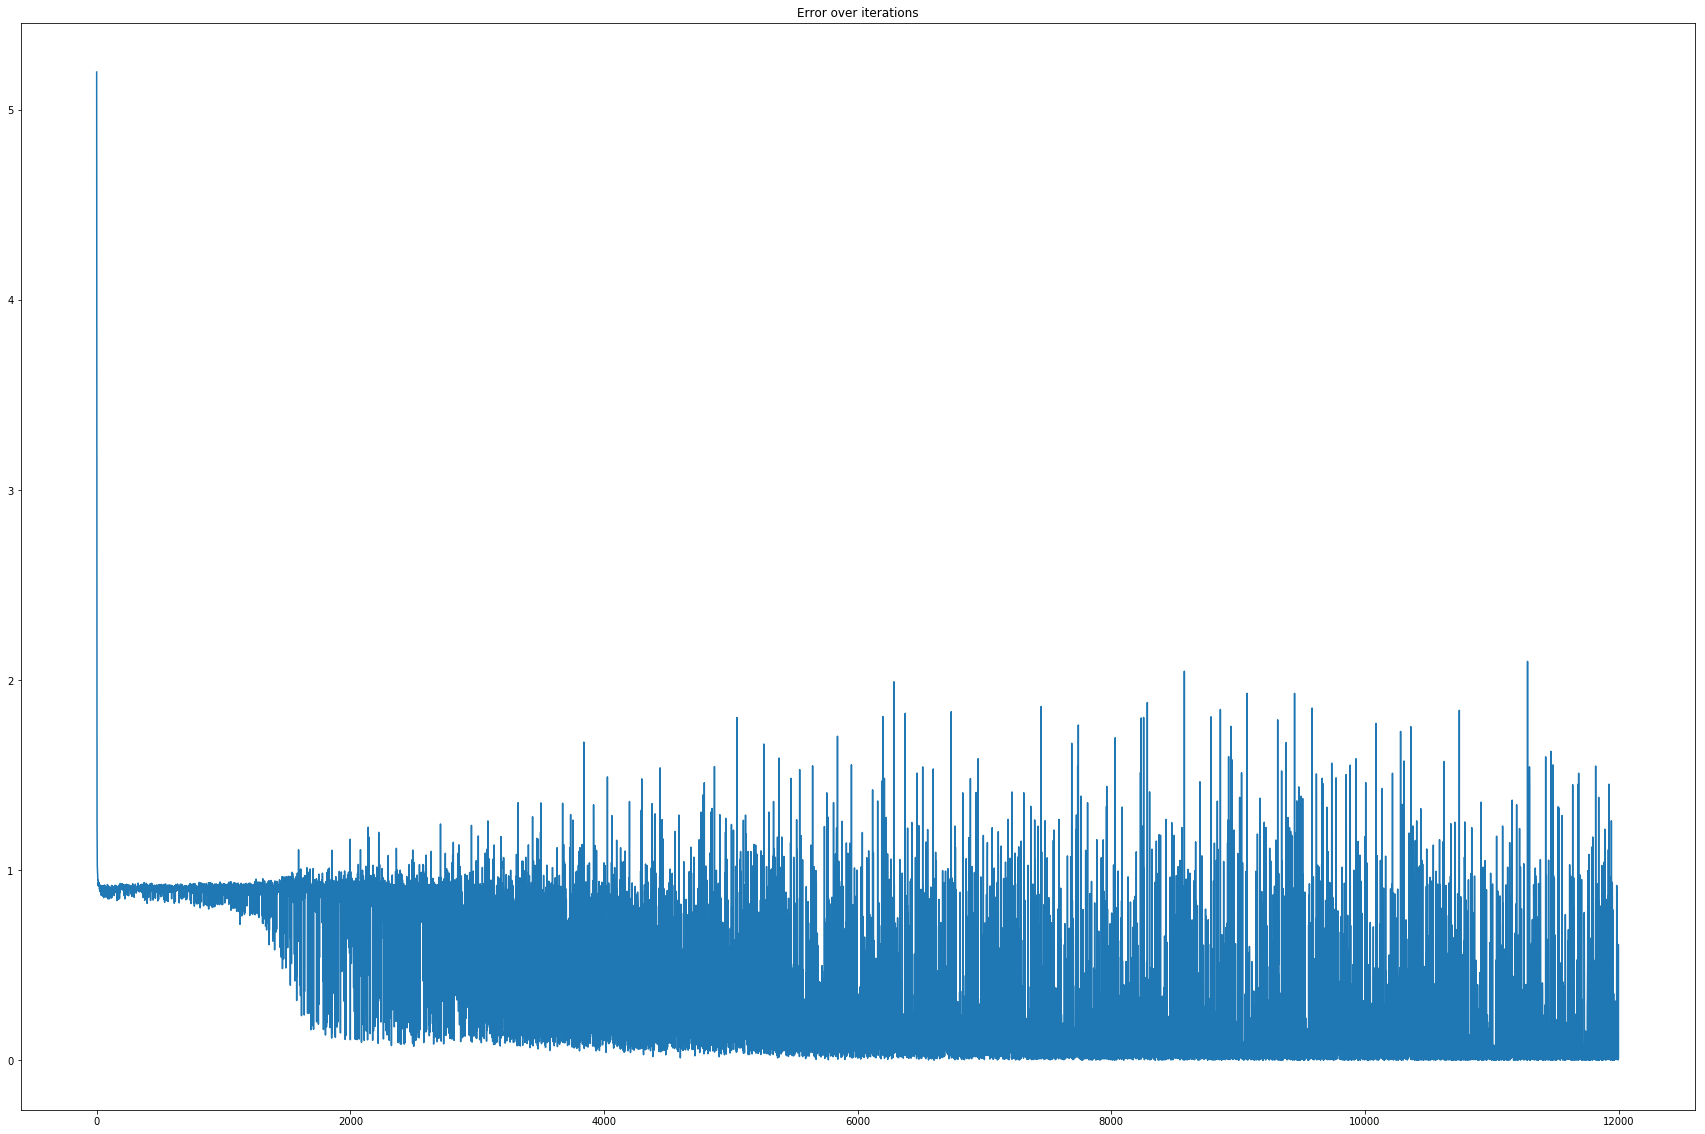

In [164]:
layers = [28**2, 100, 10]
activations = [sigmoid, sigmoid]
np.random.seed(0)
mnist_net_sig = NeuralNetwork(layers, activations)

mnist_net_sig.bgdc(mnist_examples[0:50000], mnist_labels[0:50000],
              mnist_examples[50000:60000], mnist_labels[50000: 60000],
              epochs = 40,
              batches = 300,
              batch_size = 100,
              alpha = 1.2,
              dropout = 0.1)

9148 / 10000


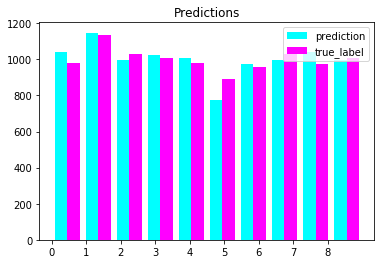

In [168]:
mnist_net_sig.test(mnist_test_examples, mnist_test_labels)

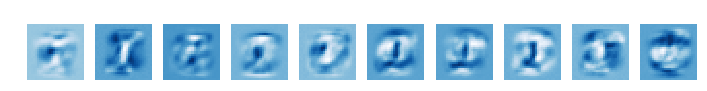

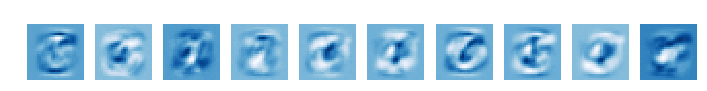

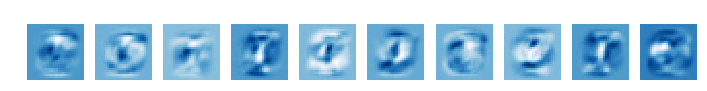

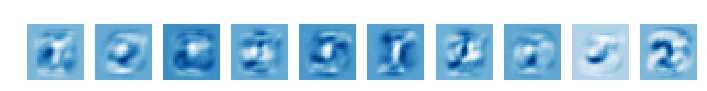

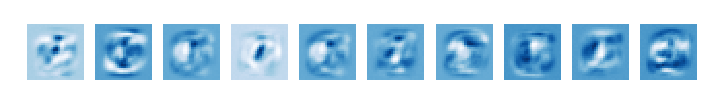

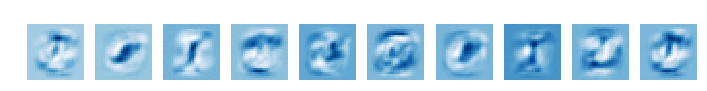

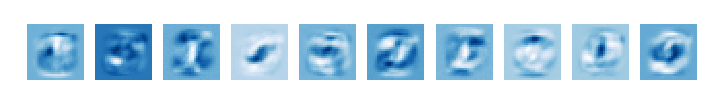

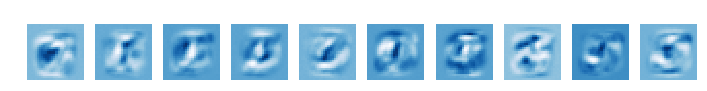

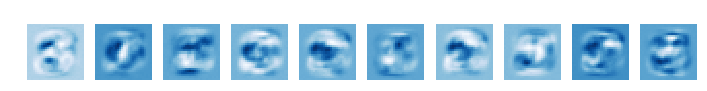

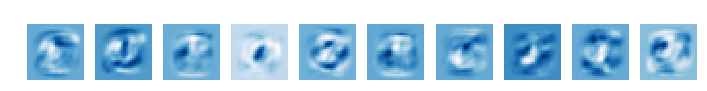

Summed weights: 


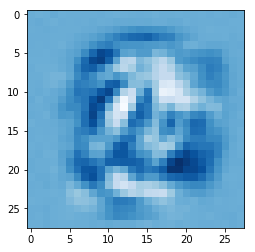

In [169]:
img_dim = (28, 28)
display_weights(mnist_net_sig.weights[0], img_dim)

> The ```sigmoid```-netowrk unlike the ```tanh```-network begins the first $4$ epochs without much improvement. The network overfits to predicting $1$ on every example. A change in behaviour is then displayed in epoch $5$ when the network finaly shows signs of generalization. from there it improves somewhat. It is unclear why this happens, maybe a bigger learning rate will accelerate learning, but that might make the optimization jump past local minima as training progresses, rendering convergence impossible. This however means that the error graph shows a steady decline in the beginning where small steps are taken downwards. It then starts the same oscilation shown in the tanh-network. Towards the last epochs the average loss and accuracy starts oscilating instead of steadily decreasing, meaning the network probably starts overfitting a little bit. Validation and test accuracy are still higher than the epoch accuracy, showing a slight degree of generalization (this appears to happen in every network towards the end of training).

### ```l_relu```

Epoch: 1, Avg. Loss: 0.701757270880006, Avg. accuracy: 0.5669666666666662
Time: 30 seconds
Validation Accuracy
7925 / 10000


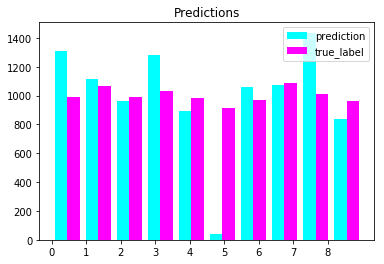

Epoch: 2, Avg. Loss: 0.4702362016092108, Avg. accuracy: 0.7518333333333337
Time: 30 seconds
Validation Accuracy
8504 / 10000


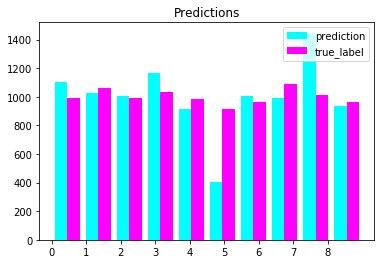

Epoch: 3, Avg. Loss: 0.4086752550592084, Avg. accuracy: 0.7995666666666674
Time: 30 seconds
Validation Accuracy
8620 / 10000


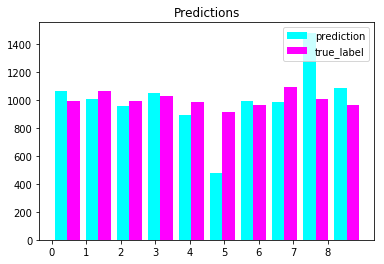

Epoch: 4, Avg. Loss: 0.3991000990447393, Avg. accuracy: 0.8179333333333342
Time: 30 seconds
Validation Accuracy
8707 / 10000


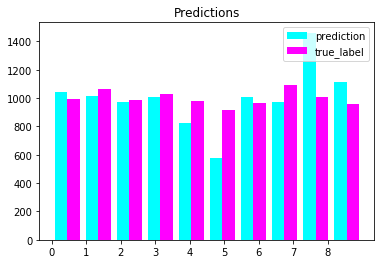

Epoch: 5, Avg. Loss: 0.3366453154936412, Avg. accuracy: 0.8272333333333338
Time: 30 seconds
Validation Accuracy
8655 / 10000


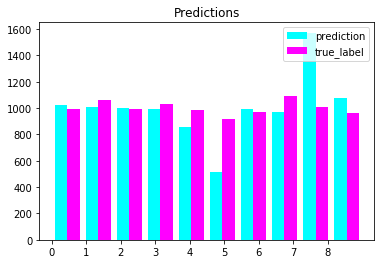

Epoch: 6, Avg. Loss: 0.3866215103112881, Avg. accuracy: 0.8365333333333337
Time: 32 seconds
Validation Accuracy
8844 / 10000


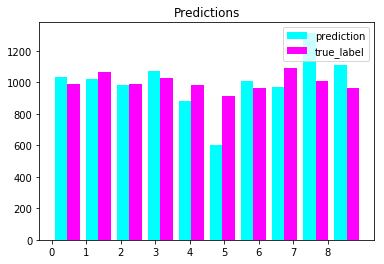

Epoch: 7, Avg. Loss: 0.3692286718210765, Avg. accuracy: 0.8428000000000005
Time: 31 seconds
Validation Accuracy
8887 / 10000


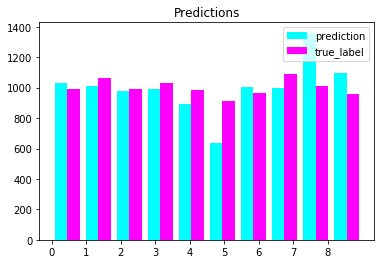

Epoch: 8, Avg. Loss: 0.323588835447018, Avg. accuracy: 0.8489333333333333
Time: 31 seconds
Validation Accuracy
8890 / 10000


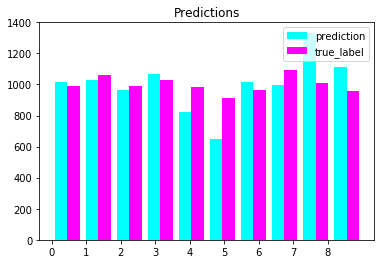

Epoch: 9, Avg. Loss: 0.3029385676754946, Avg. accuracy: 0.8500000000000005
Time: 30 seconds
Validation Accuracy
8979 / 10000


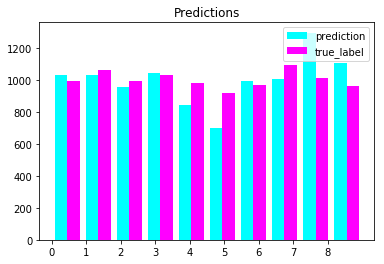

Epoch: 10, Avg. Loss: 0.3243471549849508, Avg. accuracy: 0.8553666666666675
Time: 30 seconds
Validation Accuracy
8912 / 10000


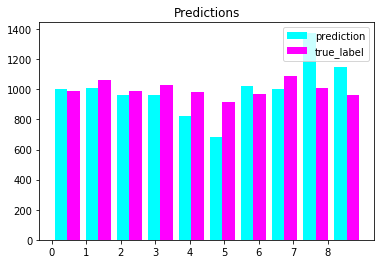

Epoch: 11, Avg. Loss: 0.3360499477659449, Avg. accuracy: 0.8527000000000012
Time: 30 seconds
Validation Accuracy
9013 / 10000


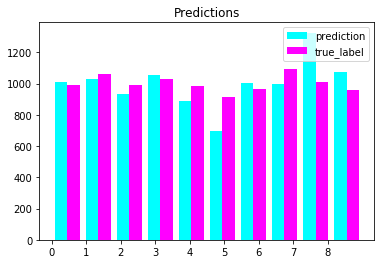

Epoch: 12, Avg. Loss: 0.3884448920572579, Avg. accuracy: 0.857600000000001
Time: 30 seconds
Validation Accuracy
9022 / 10000


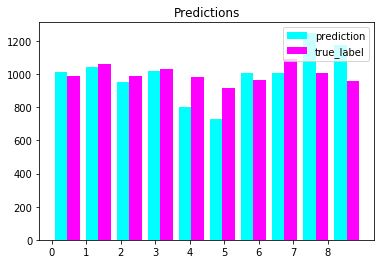

Epoch: 13, Avg. Loss: 0.3330241661771442, Avg. accuracy: 0.8615666666666671
Time: 29 seconds
Validation Accuracy
9092 / 10000


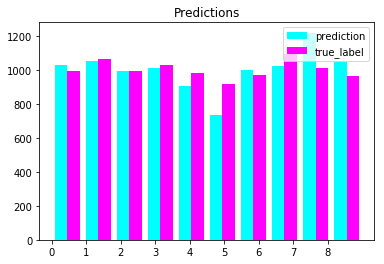

Epoch: 14, Avg. Loss: 0.3470918664516342, Avg. accuracy: 0.8637000000000006
Time: 32 seconds
Validation Accuracy
9147 / 10000


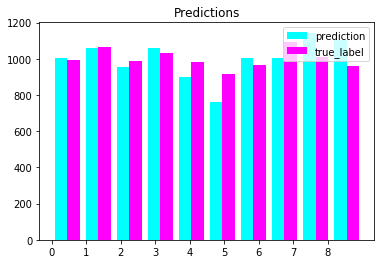

Epoch: 15, Avg. Loss: 0.40368350676616327, Avg. accuracy: 0.8617666666666676
Time: 29 seconds
Validation Accuracy
9095 / 10000


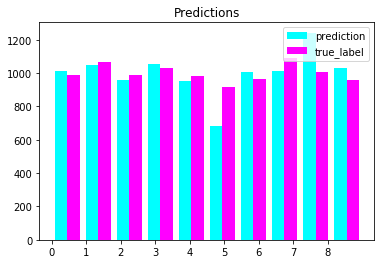

Epoch: 16, Avg. Loss: 0.34380372596382514, Avg. accuracy: 0.8633666666666674
Time: 28 seconds
Validation Accuracy
9087 / 10000


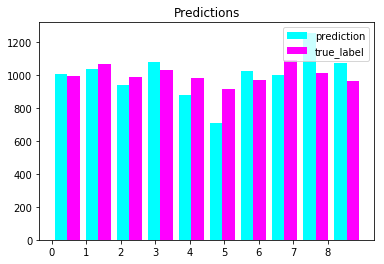

Epoch: 17, Avg. Loss: 0.3882577101297285, Avg. accuracy: 0.8637000000000008
Time: 28 seconds
Validation Accuracy
9153 / 10000


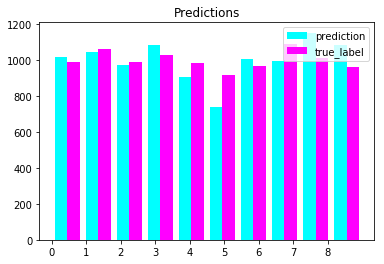

Epoch: 18, Avg. Loss: 0.37837621183346976, Avg. accuracy: 0.8638999999999994
Time: 30 seconds
Validation Accuracy
9173 / 10000


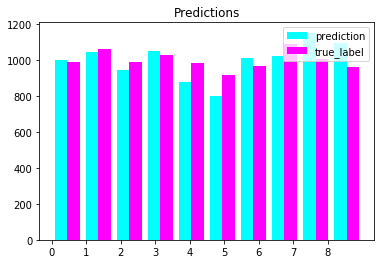

Epoch: 19, Avg. Loss: 0.33775190010121436, Avg. accuracy: 0.8687
Time: 31 seconds
Validation Accuracy
9191 / 10000


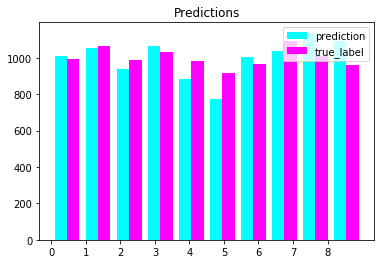

Epoch: 20, Avg. Loss: 0.370764249455164, Avg. accuracy: 0.8628333333333335
Time: 31 seconds
Validation Accuracy
9242 / 10000


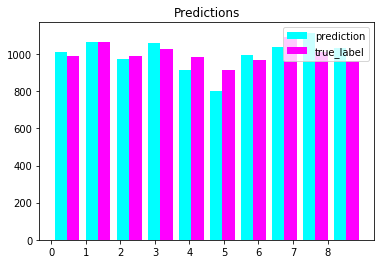

Epoch: 21, Avg. Loss: 0.3650537216519876, Avg. accuracy: 0.8629333333333337
Time: 29 seconds
Validation Accuracy
9151 / 10000


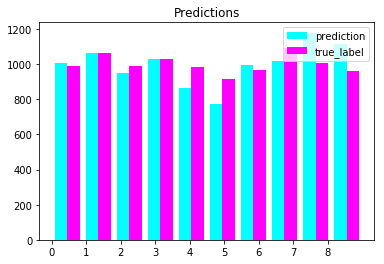

Epoch: 22, Avg. Loss: 0.3420029428783923, Avg. accuracy: 0.8712666666666669
Time: 30 seconds
Validation Accuracy
9154 / 10000


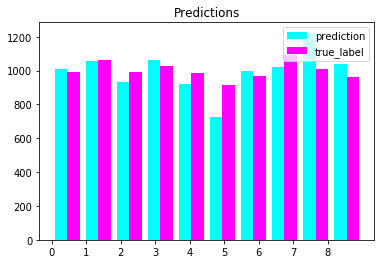

Epoch: 23, Avg. Loss: 0.3396312620305895, Avg. accuracy: 0.8678000000000005
Time: 28 seconds
Validation Accuracy
9243 / 10000


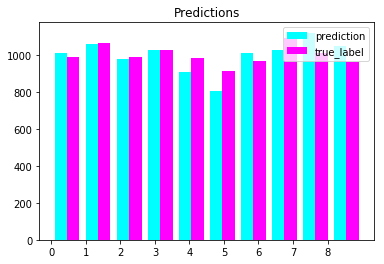

Epoch: 24, Avg. Loss: 0.36808467069206274, Avg. accuracy: 0.8684666666666664
Time: 29 seconds
Validation Accuracy
9217 / 10000


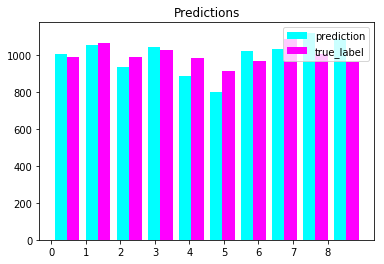

Epoch: 25, Avg. Loss: 0.3600372290774169, Avg. accuracy: 0.8705333333333333
Time: 29 seconds
Validation Accuracy
9115 / 10000


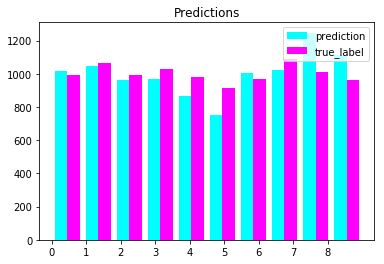

Epoch: 26, Avg. Loss: 0.31146808033699436, Avg. accuracy: 0.8699333333333338
Time: 30 seconds
Validation Accuracy
9285 / 10000


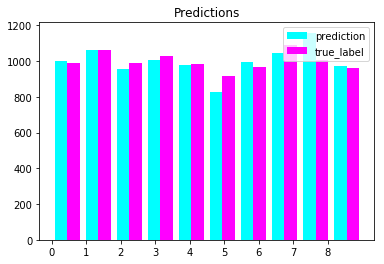

Epoch: 27, Avg. Loss: 0.32836861624737423, Avg. accuracy: 0.8724666666666668
Time: 30 seconds
Validation Accuracy
9214 / 10000


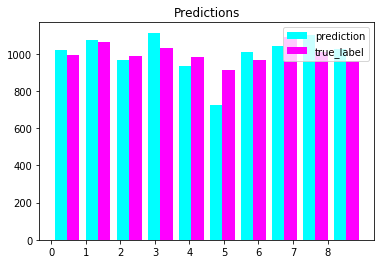

Epoch: 28, Avg. Loss: 0.328830629235544, Avg. accuracy: 0.8692999999999995
Time: 28 seconds
Validation Accuracy
9239 / 10000


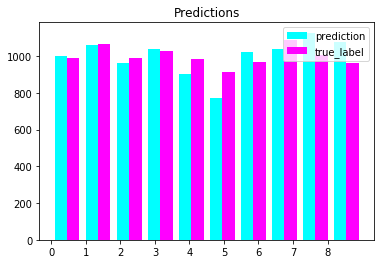

Epoch: 29, Avg. Loss: 0.36499990131462107, Avg. accuracy: 0.8707999999999992
Time: 33 seconds
Validation Accuracy
9238 / 10000


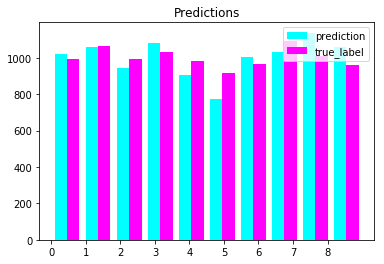

Epoch: 30, Avg. Loss: 0.4029103748996859, Avg. accuracy: 0.8690333333333337
Time: 27 seconds
Validation Accuracy
9253 / 10000


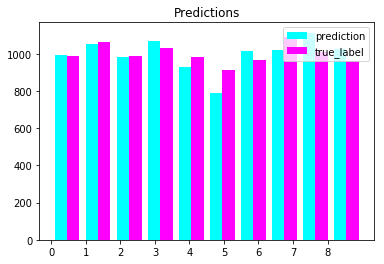

Epoch: 31, Avg. Loss: 0.33160542858126507, Avg. accuracy: 0.8699333333333336
Time: 28 seconds
Validation Accuracy
9219 / 10000


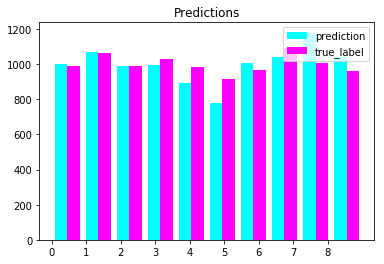

Epoch: 32, Avg. Loss: 0.3886444010066139, Avg. accuracy: 0.8715333333333335
Time: 28 seconds
Validation Accuracy
9249 / 10000


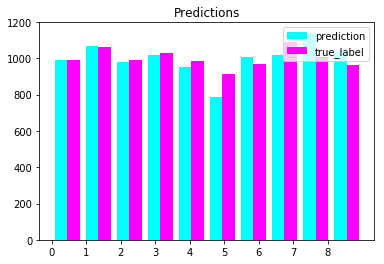

Epoch: 33, Avg. Loss: 0.37262057979368696, Avg. accuracy: 0.8716999999999998
Time: 29 seconds
Validation Accuracy
9258 / 10000


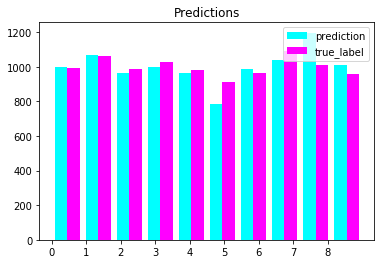

Epoch: 34, Avg. Loss: 0.3648508700661209, Avg. accuracy: 0.874266666666667
Time: 28 seconds
Validation Accuracy
9216 / 10000


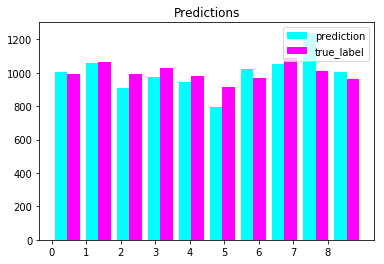

Epoch: 35, Avg. Loss: 0.37781160183655743, Avg. accuracy: 0.8731333333333328
Time: 30 seconds
Validation Accuracy
9260 / 10000


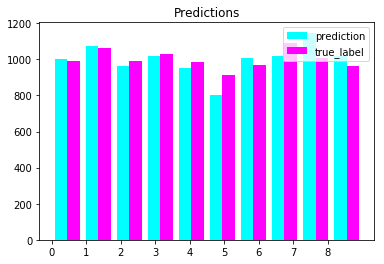

Epoch: 36, Avg. Loss: 0.3594231182924708, Avg. accuracy: 0.8706999999999999
Time: 29 seconds
Validation Accuracy
9239 / 10000


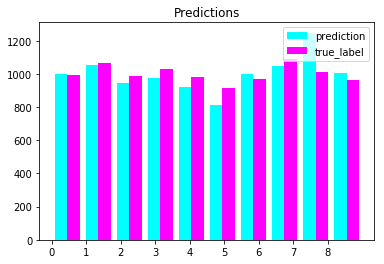

Epoch: 37, Avg. Loss: 0.3236208007584701, Avg. accuracy: 0.8717333333333331
Time: 32 seconds
Validation Accuracy
9307 / 10000


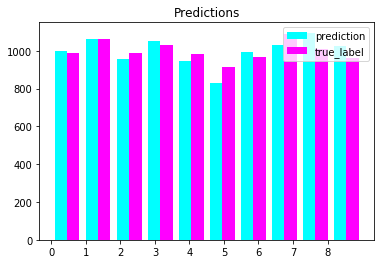

Epoch: 38, Avg. Loss: 0.354323272288508, Avg. accuracy: 0.8727333333333339
Time: 29 seconds
Validation Accuracy
9261 / 10000


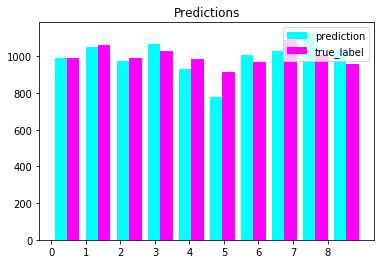

Epoch: 39, Avg. Loss: 0.36028557292443386, Avg. accuracy: 0.8728333333333332
Time: 29 seconds
Validation Accuracy
9246 / 10000


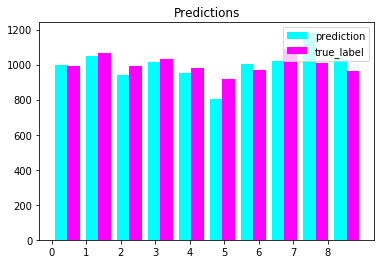

Epoch: 40, Avg. Loss: 0.3356720919389556, Avg. accuracy: 0.8767666666666668
Time: 28 seconds
Validation Accuracy
9253 / 10000


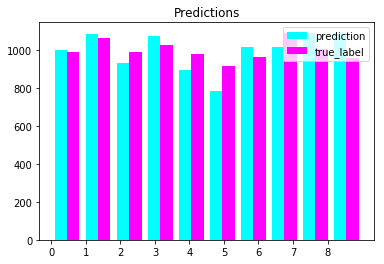

3.2442006747726264 0.008719408319407686


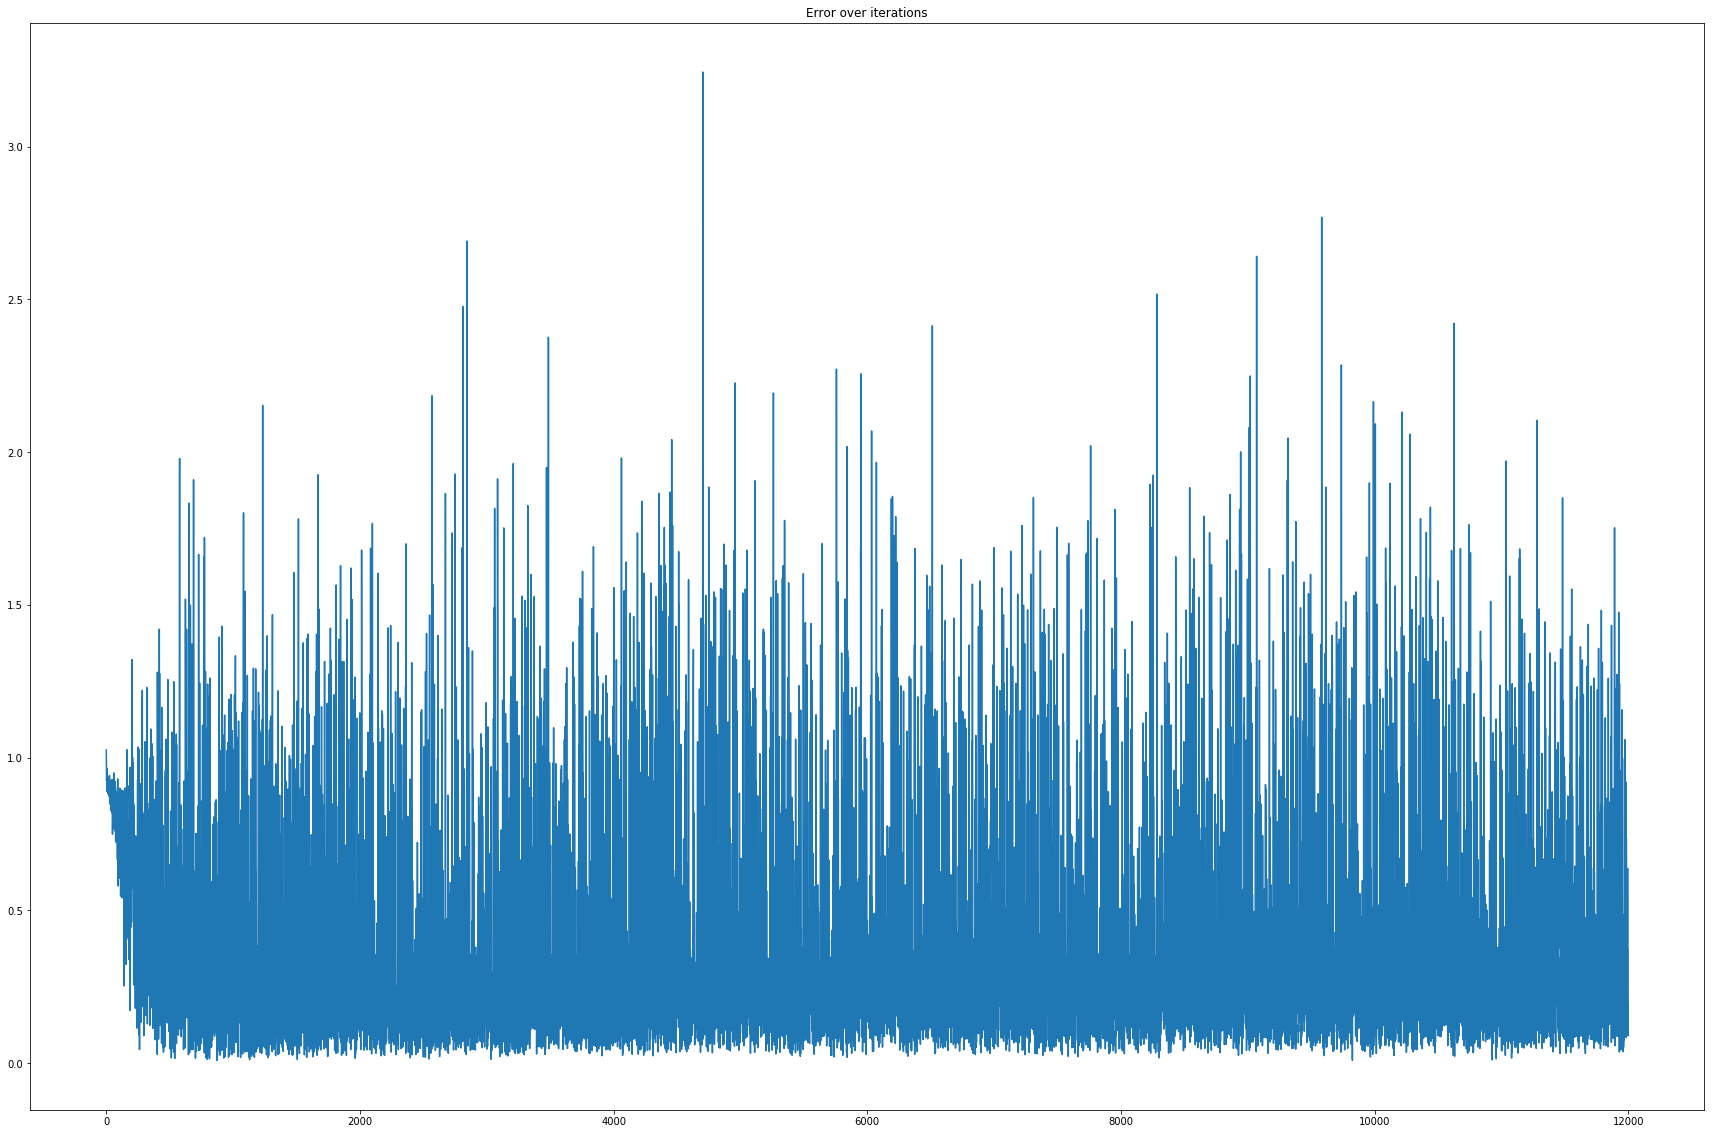

In [154]:
layers = [28**2, 100, 10]
activations = [l_relu, l_relu]
np.random.seed(0)
mnist_net_relu = NeuralNetwork(layers, activations)

mnist_net_relu.bgdc(mnist_examples[0:50000], mnist_labels[0:50000],
              mnist_examples[50000:60000], mnist_labels[50000: 60000],
              epochs = 40,
              batches = 300,
              batch_size = 100,
              alpha = 0.08,
              dropout = 0.4)

9203 / 10000


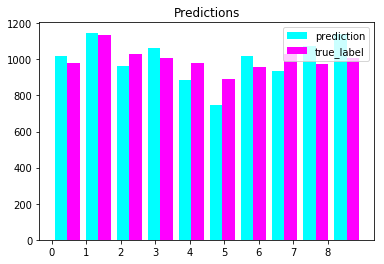

In [170]:
mnist_net_relu.test(mnist_test_examples, mnist_test_labels)

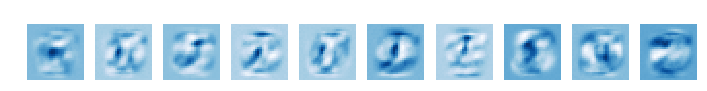

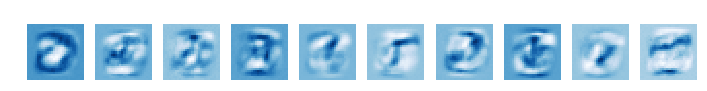

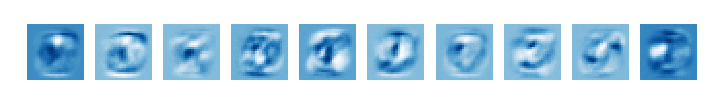

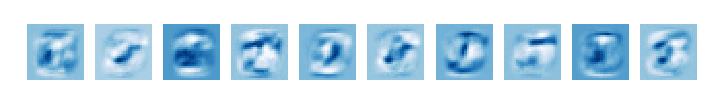

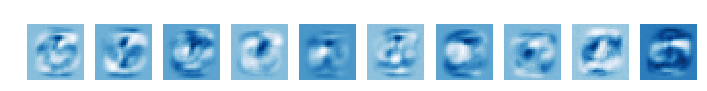

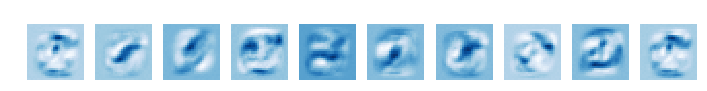

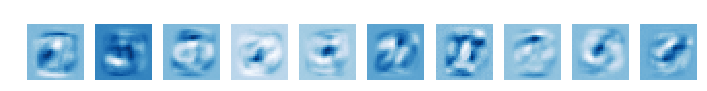

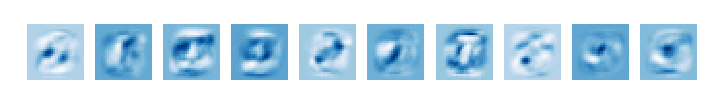

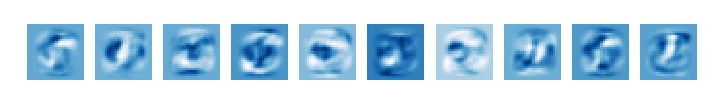

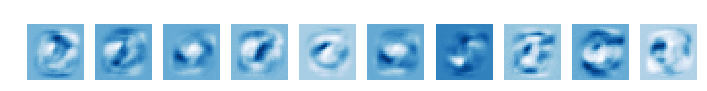

Summed weights: 


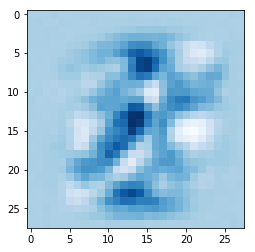

In [172]:
img_dim = (28, 28)
display_weights(mnist_net_relu.weights[0], img_dim)

> In contrast to the other activation functions, ```l_relu``` has a codomain of continous numbers meaning the signal can rise to practically impossible numbers (or rather, computationally unstable numbers). It is therefore better to increase the dropout to decrease the magnitude of the signals. This means the network will generalize better, but training will take longer since the same training example will provide slightly different signals every time it is fed forward. This is probably the reason why the loss starts oscilating towards the 15th epoch. With this much dropout it makes sense to train it for more epochs. This generalization appears to be the reason for the high accuracy on validation ($92$%) while the last epoch accuracy was $87$%. Test accuracy is similar to validation in this case.


### Weights

> I was originally going to discuss the weights separately for each network. But since they are all extremely similar, I will write about my conclusion here. As previously stated, dark color is correlated with a high signal. I therefore find it interresting how all weights have a slight tint around the edges of the image. For MNIST, these edges are never used i.e. The values there are $0$. This goes to show that it is not as easy as expected to predict behaviours of the network. Knowing the data beforehand, would it not make sense to make all corners $0$ since their signals always become $0$ during feed-forwarding? Another interresting observation is one that does confirm one assumption I originally had: _The weights form as pictures of what each neuron reacts to_.This is proven by the circular shape every image contains in the center. Some images clearly resemble the number one (or simply a straight line) which makes sense as many images has signals that occur in the center of the image.

> Looking at them quickly we can observe some patterns that (according to me) resembles the numbers $0, 1, 3, 5$ and $7$. A white number could be thought of as _not_ that number and so on. It is also interresting that the spots of clear white (the absense of signals) appear in the precise center of most images, which is probably a result of generalization, where the network tries to avoid overfitting to signals in the exact center of the image. When most examples includes signals in the center, it makes sense to disregard the center and concentrate on other characteristics.

> I also wanted to examine the weights between the hidden- and output-layer. I decided against including visualization for them here since they (to the naked eye) appear to be random noise which _just makes the network work_. Further testing is required to make sense of them on my part.

> Finally, the first set of weights appear to always take a variation of this form, no matter how many hidden-layers separate the input from the output. Continuing testing with this could prove useful, as we can observe what the network is meant to do and how it works by looking at the weights as images. We can also detect a few faults in how they are shaped (the strong signals in the corners of the images which will never have any corresponding pixels). Maybe we can modify them in other ways to find a _optimized_ model that works well. And since this behaviour occurs in the corners, can we be certain that the centers actually are as _tuned_ as they should be? (There might be somethig to study here!)


### Conclusion

> The network is not proven to be the _best_ that it can be. Maybe better accuracies can be achieved with more layers, or maybe we could achieve even better preformance by decreasing the size of the hidden-layer (a hidden-layer of size 4 managed to get >$80$% accuracy in a test run). 

> The results shown here can definately be improved by tweaking the hyperparameters further. For example, increasing the number of epochs and batches and increasing dropout in certain networks. The learning rate is quite hard to choose, limiting training to $40$ epochs with $300$ batches of size $100$ for each epoch I had to change the ```alpha``` value for each network after testing. Testing each network is, as expected, the biggest bottle neck for these kinds of projects. I originally used $600$ batches with $100$ examples in each batch every epoch, but that meant I had to wait over $44$ minutes for every test. Some tests proved even more difficult when my computer slowed down, making every epoch take around $2$ minutes, extending training for hours. More layers further increased time required for training, which is why I opted to use this simple architecture.

> I believe constructing a method for observing the weights and introducing _smart_ changes to them can be a promising way of improving the way we train networks. Developing this method proves to be too much for this small course project however.